<h1>Genetic Algorithm as an Optimisation Function</h1>
<h3>Search for global minimum</h3>
<p>Note: All test functions are adapted from <a href="https://www.sfu.ca/~ssurjano/optimization.html">https://www.sfu.ca/~ssurjano/optimization.html</a></p>

In [1]:
#load the libraries
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
import math
import random
from bitstring import BitArray

In [2]:
def bits_required(lowerrange,upperrange):#no of bits required to represent the range of integers
    range=upperrange-lowerrange+1;
    curmax=1;
    curnobits=0;
    while curmax<range:
        curnobits+=1;
        curmax=(2**curnobits);
    return curnobits;

In [3]:
def init_population(no_of_hypotheses,dim,lowerrange,upperrange,scale):
    total_no_bits=bits_required(lowerrange*scale,upperrange*scale); #as the range is -30 to 30 x scale (for decimal places -> floating points)
    population = list();
    for i in range(no_of_hypotheses):
        obj=list();
        for j in range(dim):
            s = random.randint(0, 2**total_no_bits-1);
            b=BitArray(uint=s, length=total_no_bits);
            if (b.int>upperrange):b=BitArray(uint=upperrange, length=total_no_bits);#make sure that it is within the upper bound
            if (b.int<lowerrange):b=BitArray(int=lowerrange, length=total_no_bits);#make sure that it is within the lower bound
            obj.append(b);
        population.append(obj);
    return total_no_bits,population;

In [173]:
def fitness(hypotheses,scale,func,minima,minthreshold):
    #minima -> True if we are searching for minima otherwise search for maxima
    #minthreshold -> (0 = include all to 1 remove all) remove those population with poor fitness values from the selection process
    sum=0;
    minvalue=99999;
    maxvalue=-9999;
    minpos=np.zeros(2);
    maxpos=np.zeros(2);
    fit=np.zeros(len(hypotheses));
    for i in range(len(hypotheses)):
        f=func(hypotheses[i][0].int/scale,hypotheses[i][1].int/scale);
        fit[i]=f;
        if (f<minvalue):
            minpos[0]=hypotheses[i][0].int/scale;
            minpos[1]=hypotheses[i][1].int/scale;
            minvalue=f;
        if (f>maxvalue):
            maxvalue=f;
            maxpos=[hypotheses[i][0].int/scale,hypotheses[i][1].int/scale];
        sum+=f;
    fit/=sum;
    lowest=minvalue/sum;
    highest=maxvalue/sum;
    if (minima):
        fit=1-fit;
        fit/=len(fit);
        lowest=(1-lowest)/len(fit);
        highest=(1-highest)/len(fit);
        tmp=lowest;
        lowest=highest;
        highest=tmp;
    threshold=(highest*(minthreshold)+lowest*(1-minthreshold));
    psum=0;
    for i in range(len(fit)):
        if (fit[i]<threshold):
            fit[i]=0;
        psum+=fit[i];
    fit/=psum;
    return minvalue,minpos,maxvalue,maxpos,fit;
def selection(hypotheses,distribution):
    noparents=int(len(hypotheses)/2);
    indx=list(range(0,len(hypotheses)));
    selectedpairs=list();
    for i in range(noparents):
        parent1=random.choices(indx,distribution);
        parent2=random.choices(indx,distribution);
        maxtried=0;
        while (parent2==parent1 and maxtried<1000):
            parent2=random.choices(indx,distribution);
            maxtried+=1;
        selectedpairs.append(hypotheses[parent1[0]]);
        selectedpairs.append(hypotheses[parent2[0]]);
    return selectedpairs;
def swapbits(data1,data2,crossoverbit,totalnobits):#swap from crossoverbit (i.e cross over at that bit)
    child1=data1.copy();
    child1[0:crossoverbit]=data2[0:crossoverbit];
    child2=data1.copy();
    child2[crossoverbit:totalnobits]=data2[crossoverbit:totalnobits];
    return child1,child2;
def crossover(selected,crossoverbit,totalnobits):
    children=list();
    for i in range(0,len(selected),2):
        child1x,child2x=swapbits(selected[i][0],selected[i+1][0],crossoverbit,totalnobits);
        child1y,child2y=swapbits(selected[i][1],selected[i+1][1],crossoverbit,totalnobits);
        children.append([child1x,child1y]);
        children.append([child2x,child2y]);
    return children;
def mutation(hypotheses,mutation_prob,totalnobits):
    no_mutants=int(len(hypotheses)*mutation_prob);
    result=list();
    for i in range(len(hypotheses)):
        result.append(hypotheses[i]);
    for i in range(no_mutants):
        indx=int(random.random()*len(hypotheses));
        mutatedbit=int(random.random()*totalnobits);
        whichdim=int(random.random()*2);
        result[indx][whichdim][mutatedbit]=not result[indx][whichdim][mutatedbit];
    return result;


In [54]:
def GA_Find_GlobalMinima(obj_func,population_size,minrange,maxrange,scale,no_generations,threshold,
                         mutationratio,targetmin,targelocation):
    #Find the global minima of an obj function    
    #threshold: ignore those low fitness hypothesis from the selection process
    #mutationratio: ratio of the hypotheses will be mutated
    #scale: instead of integers, scale the values up to support floating point (decimal places)
    total_no_bits,population=init_population(population_size,2,minrange,maxrange,scale);
    curminvalue=[];
    for generation in range(no_generations):
        minvalue,minpos,maxvalue,maxpos,distribution=fitness(population,scale,obj_func,True,threshold);  
        selectedpairs=selection(population,distribution);
        newpopulation=crossover(selectedpairs,3,total_no_bits);#cross over at bit 3
        mutatedpopulation=mutation(newpopulation,mutationratio,total_no_bits);#the prob of mutation is 1%
        curminvalue.append(minvalue);
        population=mutatedpopulation;   
    print("target global min=",targetmin," at ",targelocation);
    print("result global min=",minvalue," at ",minpos);
    plt.plot(curminvalue);
    plt.show();

In [411]:
def Plot_func(obj_func,xminrange,xmaxrange,yminrange,ymaxrange,func_name):#plot the objective function
    x = np.outer(np.linspace(xminrange, xmaxrange, 50), np.ones(50))#create 2D array for ploting on a 3D graph
    y = np.outer(np.linspace(yminrange, ymaxrange, 50), np.ones(50)).T
    z=obj_func(x,y);
    #create the figure and plot the 3D graph
    fig = plt.figure()
    #fig.set_size_inches(18.5, 10.5)
    fig.set_size_inches(9, 5)
    plt.title(func_name)
    ax = plt.axes(projection ='3d')
    #ax.plot_surface(x, y, z, cmap ='plasma', edgecolor ='green')
    ax.plot_surface(x, y, z, cmap ='plasma')

<hr/>
<h2>Ackley Function</h2>
<p>from: <a href="https://www.sfu.ca/~ssurjano/ackley.html">https://www.sfu.ca/~ssurjano/ackley.html</a></p>
<p>$f(x)=-a\exp\left(-b\sqrt{\left(\frac{1}{d}\sum_{i=1}^{d}{x_i^2}\right)}\right)-\exp\left(\frac{1}{d}\sum_{i=1}^{d}{\cos(cx_i)}\right)+a+\exp(1)$</p>
<p>For 2 dimension (d=2)</p>
<p>$f(x)=-a\exp\left(-b\sqrt{\left(\frac{1}{2}\left(x^2+y^2\right)\right)}\right)-\exp\left(\frac{1}{2}\left(\cos(cx)+\cos(cy)\right)\right)+a+\exp(1)$</p>
<p>recommanded  $a = 20, b = 0.2$ and $c = 2π$ </p>
<p>Global minimum</p>
<p>$x^*=(0,0)$</p>

In [80]:
def Ackley_func(x,y):
    a=20;b=0.2;d=2;
    c=2*math.pi;
    return -a*np.exp(-b*np.sqrt(1/d*(x**2+y**2)))-np.exp(1/d*(np.cos(c*x)+np.cos(c*y)))+a*np.exp(1);

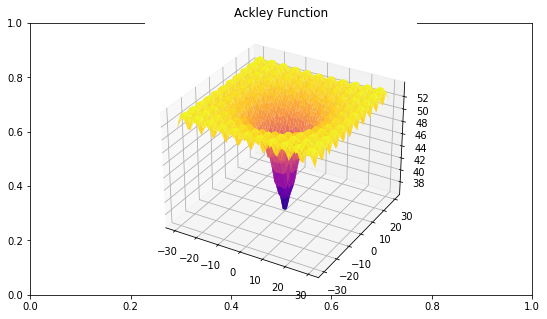

In [412]:
Plot_func(Ackley_func,-30,30,-30,30,"Ackley Function");

target global min= 31.647354740721855  at  (0,0)
result global min= 31.647354740721855  at  [0. 0.]


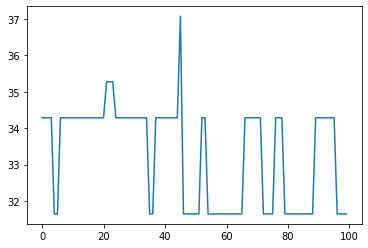

In [100]:
#Find the global minima of an Ackley function
#population size: 300
#range -30 to 30
#scale:1 (i.e integer only)
#no generations:100
#% of poor fitness will be ignored:0.5
#mutation prob: 10%
#target optimal value:Ackley_func(0,0)
#optimal location (0,0)
GA_Find_GlobalMinima(Ackley_func,300,-30,30,1,100,0.5,0.1,Ackley_func(0,0),"(0,0)");

<hr/>
<h3>Bukin Function N.6</h3>
<p>$f(x)=100\sqrt{|x_2-0.01x_1^2|}+0.01|x_1+10|$</p>
<p>$x_1\in[-15,-5], x_2 \in[-3,3]$</p>
<p>Global minimum</p>
<p>$f(x^*)=0$ at $x^*=(-10,1)$</p>

In [9]:
def Bukin_func(x,y):
    return 100*np.sqrt(np.abs(y-0.01*(x**2)))+0.01*np.abs(x+10);

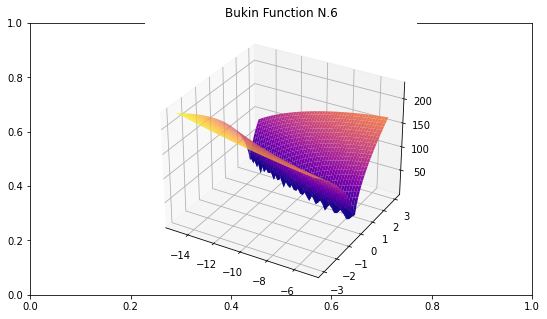

In [413]:
Plot_func(Bukin_func,-15,-5,-3,3,"Bukin Function N.6");

target global min= 0.0  at  (-10,1)
result global min= 0.0  at  [-10.   1.]


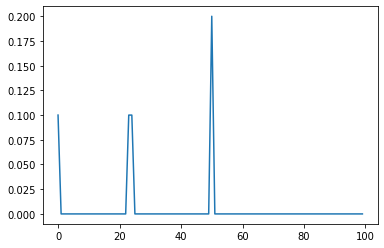

In [64]:
#Find the global minima of the Bukin function N.6
GA_Find_GlobalMinima(Bukin_func,1000,-15,15,1,100,0.5,0.05,Bukin_func(-10,1),"(-10,1)");

<hr/>
<h3>Cross-in-tray function</h3>
<p>$f(x)=-0.0001\left(\left|sin(x_1)sin(x_2)\exp\left(\left|100-\frac{\sqrt{x_1^2+x_2^2}}{\pi}\right|\right)\right|+1\right)^{0.1}$</p>
<p>Input domain</p>
<p>$x_i\in[-10,10]$ for all $i=1,2,...$</p>
<p>Global minima (at multiple locations)</p>
<p>$f(x^*)=-2.06261$ at $x=(1.3491,-1.3491),(1.3491,1.3491),(-1.3491,1.3491) and (-1.3491,-1.3491)$</p>

In [12]:
def Cross_in_tray_func(x,y):
    return -0.0001*(np.abs(np.sin(x)*np.sin(y)*np.exp(np.abs(100-np.sqrt(x**2+y**2)/math.pi)))+1)**(0.1);

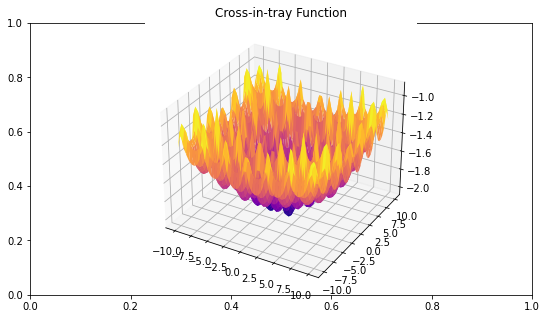

In [414]:
Plot_func(Cross_in_tray_func,-10,10,-10,10,"Cross-in-tray Function");

target global min= -2.0626118504479614  at   at (1.3491,1.3491) or (1.3491,-1.3491) or (-1.3491,1.3491), or (-1.3491,-1.3491)
result global min= -1.8779931390952873  at  [-1.29  -4.138]


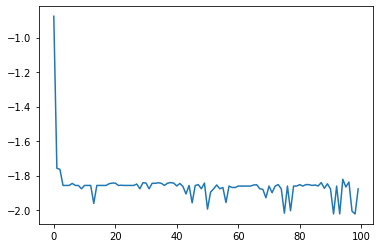

In [66]:
#Find the global minima of the Cross-in-tray function
GA_Find_GlobalMinima(Cross_in_tray_func,300,-10,10,1000,100,0.999,0.05,Cross_in_tray_func(1.3491,1.3491),
                    " at (1.3491,1.3491) or (1.3491,-1.3491) or (-1.3491,1.3491), or (-1.3491,-1.3491)");

<hr/>
<h3>Drop-wave Function</h3>
<p>$f(x)=-\frac{1+cos\left(12\sqrt{x_1^2+x_2^2}\right)}{0.5(x_1^2+x_2^2)+2}$</p>
<p>domain $x_j\in[-5.12,5.12]$ for all $i=1,2.$</p>
<p>Global Minimum:</p>
<p>$f(x^*)=-1$ at $x^*=(0,0)$</p>

In [16]:
def Drop_wave_func(x,y):
    return -(1+np.cos(12*np.sqrt(x**2+y**2)))/(0.5*(x**2+y**2)+2);

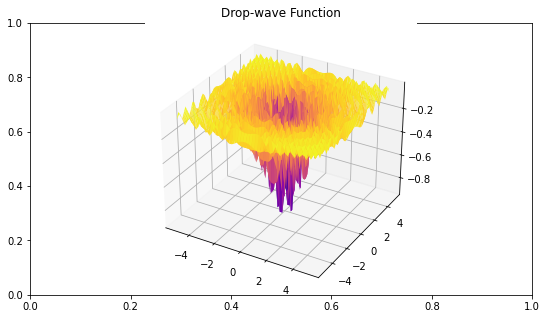

In [415]:
Plot_func(Drop_wave_func,-5.12,5.12,-5.12,5.12,"Drop-wave Function");

target global min= -1.0  at  (0,0)
result global min= -0.3511872658340727  at  [-2.57  0.15]


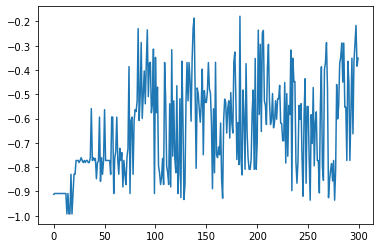

In [101]:
#Find the global minima of the Drop-wave function
GA_Find_GlobalMinima(Drop_wave_func,1000,-5,5,100,300,0.3,0.05,Drop_wave_func(0,0),"(0,0)");

<hr/>
<h3>Eggholder Function</h3>
<p>$f(x)=-(x_2+47)sin\left(\sqrt{\left|x_2+\frac{x_1}{2}+47\right|}\right)-x_1sin\left(\sqrt{|x_1-(x_2+47)|}\right)$</p>
<p>Domain $x_i\in[-512,512]$ for all $i=1,2$</p>
<p>Global Minimum</p>
<p>$f(x^*)=-959.6407$ at $x^*=(512,404.2319)$</p>

In [42]:
def Eggholder_func(x,y):
    return -(y+47)*np.sin(np.sqrt(np.abs(y+y/2+47)))-x*np.sin(np.sqrt(np.abs(x-(y+47))));

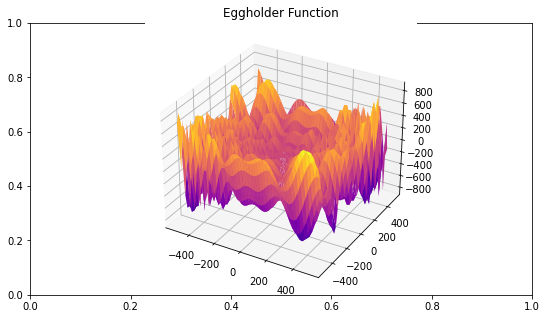

In [416]:
Plot_func(Eggholder_func,-512,512,-512,512,"Eggholder Function");

target global min= -698.3768696088275  at  (512,404.2319)
result global min= -1871.2236894390687  at  [970. 979.]


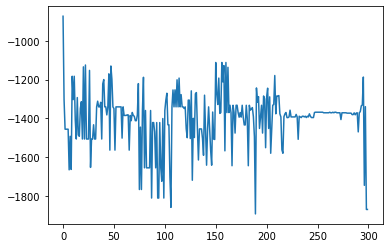

In [70]:
#Find the global minima of the Eggholder function
GA_Find_GlobalMinima(Eggholder_func,1000,-512,512,1,300,0.3,0.05,Eggholder_func(512,404.2319),"(512,404.2319)");

<h2>Griewank Function</h2>
<p>$f(x)=\sum\limits_{i=1}^d{\frac{x_i^2}{4000}}-\prod\limits_{i=1}^d\cos(\frac{x_i}{\sqrt{i}})+1$</p>
<p>So for 2 dimensions</p>
<p>$f(x)=\frac{x^2}{4000}+\frac{y^2}{4000}-\cos(x)\cos(\frac{y}{\sqrt{2}})+1$</p>
<p>Domain: $x_i\in[-600,600]$ for all $i=1,..,d$</p>
<p>Global Minimum</p>
<p>$f(x^*)=0$, at $x^*=(0,...,0)$</p>

In [86]:
def Griewank_func(x,y):
    return x**2/4000+y**2/4000-np.cos(x)*np.cos(y/np.sqrt(2))+1;

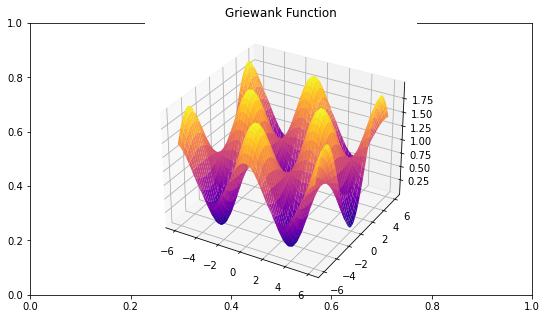

In [417]:
Plot_func(Griewank_func,-6,6,-6,6,"Griewank Function");

target global min= 0.0  at  (0,0)
result global min= 0.23737266804997126  at  [ 6.6 -9.7]


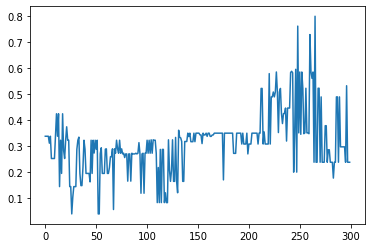

In [92]:
#Find the global minima of the Griewank function
GA_Find_GlobalMinima(Griewank_func,3000,-600,600,10,300,0.5,0.05,Griewank_func(0,0),"(0,0)");

<hr/><h2>Holder Table Function</h2>
<p>$f(x)=-\left|\sin(x_1)\cos(x_2)\exp\left(\left|1-\frac{\sqrt{x_1^2+x_2^2}}{\pi}\right|\right)\right|$</p>
<p>Domain $x_i\in[-10,10]$ for all $i=1,2$</p>
<p>Global Minimum</p>
<p>$f(x^*)=-19.2085$ at $x^*=(8.05502,9.66459),(8.05502,-9.66459),(-8.05502,9.66459),(-8.05502,-9.66459)$</p>

In [93]:
def Holder_func(x,y):
    return -np.abs(np.sin(x)*np.cos(y)*np.exp(np.abs(1-np.sqrt(x**2+y**2)/np.pi)));

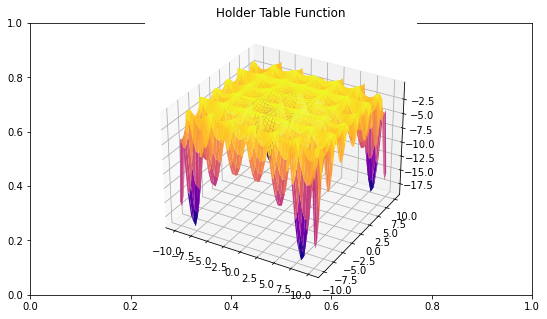

In [418]:
Plot_func(Holder_func,-10,10,-10,10,"Holder Table Function");

target global min= -19.208502567767606  at  (8.05502,9.66459),(-8.05502,9.66459),(8.05502,-9.66459),(-8.05502,-9.66459)
result global min= -17.94535230941161  at  [10.14 -9.15]


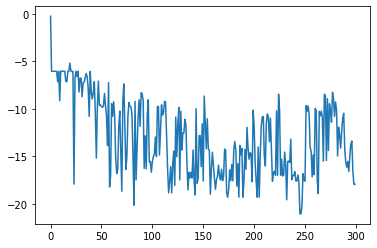

In [99]:
#Find the global minima of the Holder Table function
GA_Find_GlobalMinima(Holder_func,1000,-10,10,100,300,0.99,0.05,Holder_func(8.05502,9.66459),
                     "(8.05502,9.66459),(-8.05502,9.66459),(8.05502,-9.66459),(-8.05502,-9.66459)");

<hr/><h2>Langermann Function</h2>
<p>$f(x)=\sum\limits_{i=1}^{m}{c_i\exp\left(-\frac{1}{\pi}\sum\limits_{j=1}^d{(x_j-A_{ij})^2}\right)\cos\left(\pi\sum\limits_{j=1}^d{(x_j-A_{ij})^2}\right)}$</p>
<p>It's a multimodal function with many unevenly distributed local minima. <br/>
    for (d=2): $m=5,c=(1,2,5,2,3)$ and <br/>
    $A=\begin{pmatrix}
3 & 5\\
5 & 2\\
2 & 1\\
1 & 4\\
7 & 9\\
\end{pmatrix}$</p>
<p>So, for 2-dimension:<br/>
    $f(x)=\sum\limits_{i=1}^{5}{c_i\exp\left(-\frac{1}{\pi}((x-A_{i0})^2+(y-A_{i1}^2)\right)\cos\left(\pi((x-A_{i0})^2+(y-A_{i1})^2)\right)}$</p>
<p>Domain $x_i\in[0,10]$, for all $i=1,..,d$</p>


In [106]:
def Langermann_func(x,y):
    m=5;
    c=[1,2,5,2,3];
    A=[[3,5],[5,2],[2,1],[1,4],[7,9]];
    result=0;
    for i in range(m):
        tmp=(x-A[i][0])**2+(y-A[i][1])**2;
        result+=(c[i]*np.exp(-1/np.pi*(tmp))*np.cos(np.pi*(tmp)));
    return result;

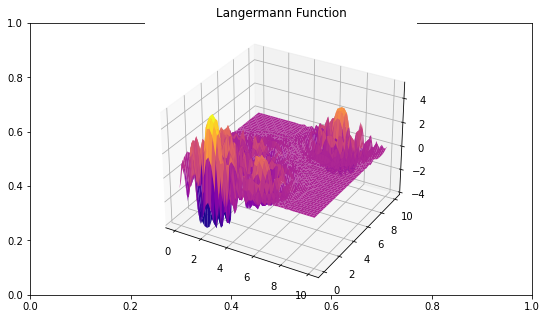

In [419]:
Plot_func(Langermann_func,0,10,0,10,"Langermann Function");

target global min= -4.11663984986056  at  unknown
result global min= -3.8104351507547967  at  [2.98 1.24]


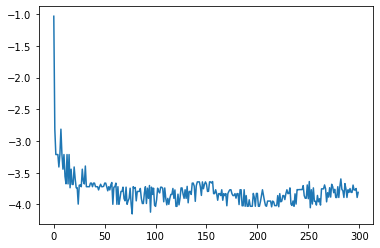

In [110]:
#Find the global minima of the Langermann function
GA_Find_GlobalMinima(Langermann_func,1000,0,10,100,300,0.99,0.05,Langermann_func(2,2),
                     "unknown");

<hr/>
<h3>Levy Function</h3>
<p>$f(x)=\sin^2(\pi w_1)+\sum\limits_{i=1}^{d-1}{(w_i-1)^2[1+10\sin^2(\pi w_i+1)]+(w_d-1)^2[1+\sin^2(2\pi w_d)]}$<br/>
where $w_i=1+\frac{x_i-1}{4}$ for all $i=1,..,d$</p>
<p>For 2D<br/>
<p>$f(x)=\sin^2\left(\pi \left(1+\frac{x-1}{4}\right)\right)+\left(\frac{x-1}{4}\right)^2\left[1+10\sin^2\left(\pi \left(1+\frac{x-1}{4}\right)+1\right)\right]+\left(\frac{y-1}{4}\right)^2\left[1+\sin^2\left(2\pi \left(1+\frac{y-1}{4}\right)\right)\right]$<br/>
</p>    
<p>Domain $x_i\in[-10,10]$ for all $i=1,..,d$</p>
<p>Global Minimum</p>
<p>$f(x^*)=0$ at $x^*=(1,...,1)$</p>

In [111]:
def Levy_func(x,y):
    tmpx=(x-1)/4;
    tmpy=(y-1)/4;
    return (np.sin(np.pi*(1+tmpx)))**2+(tmpx**2)*(1+10*(np.sin(np.pi*(1+tmpx)+1))**2)+(tmpy**2)*(1+(np.sin(2*np.pi*(1+tmpy)))**2);

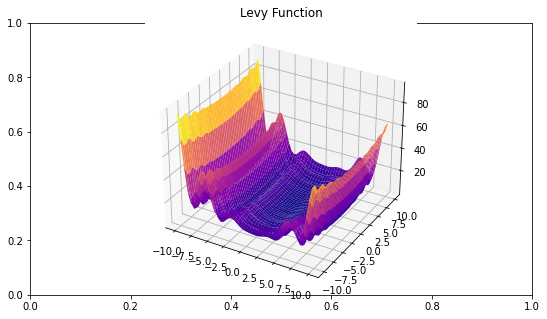

In [420]:
Plot_func(Levy_func,-10,10,-10,10,"Levy Function");

target global min= 0.00  at  (1,1)
result global min= 0.003760249642404903  at  [1.03 0.8 ]


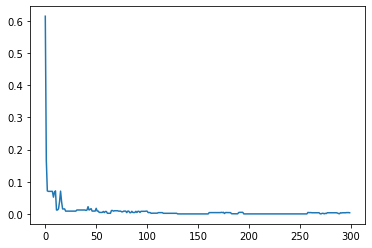

In [117]:
#Find the global minima of the Levy function
GA_Find_GlobalMinima(Levy_func,1000,-10,10,100,300,0.99,0.05,"{:0.2f}".format(Levy_func(1,1)),
                     "(1,1)");

<hr/>
<h2>Levy Function N.13</h2>
<p>$f(x)=\sin^2(3\pi x_1)+(x_1-1)^2[1+\sin^2(3\pi x_2)]+(x_2-1)^2[1+\sin^2(2\pi x_2)]$</p>
<p>Domain $x_i\in[-10,10]$ for all $i=1,2$</p>
<p>Global Minimum</p>
<p>$f(x^*)=0$ at $x^*=(1,1)</p>

In [120]:
def Levy_funcN13(x,y):
    return (np.sin(3*np.pi*x))**2+((x-1)**2)*(1+(np.sin(3*np.pi*y))**2)+((y-1)**2)*(1+(np.sin(2*np.pi*y))**2);

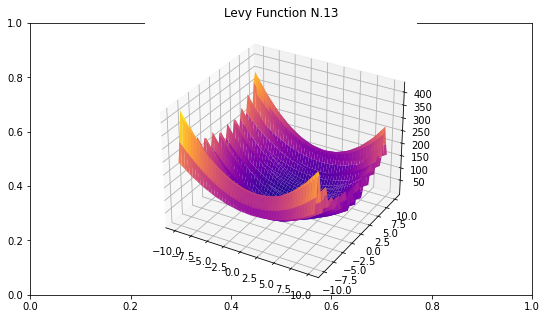

In [421]:
Plot_func(Levy_funcN13,-10,10,-10,10,"Levy Function N.13");

target global min= 0.00  at  (1,1)
result global min= 0.1336841803676731  at  [1.32 0.96]


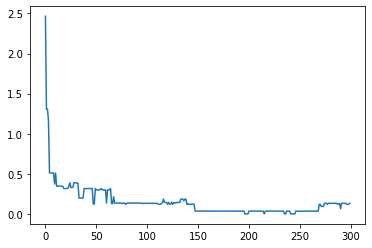

In [122]:
#Find the global minima of the Levy function N.13
GA_Find_GlobalMinima(Levy_funcN13,1000,-10,10,100,300,0.99,0.05,"{:0.2f}".format(Levy_funcN13(1,1)),
                     "(1,1)");

<hr/>
<h3>Rastrigin Function</h3>
<p>$f(x)=10d+\sum\limits_{i=1}^d{[x_i^2-10\cos(2\pi x_i)]}$</p>
<p>So, for 2D<br/>
    $f(x)=20+[x^2-10\cos(2\pi x)]+[y^2-10\cos(2\pi y)]$</p>
<p>Domain $x_i=[-5.12,5.12]$ for all $i=1,..d$</p>
<p>Global Minimum</p>
<p>$f(x^*)=0$ at $x^*=(0,...,0)$</p>

In [123]:
def Rastrigin_func(x,y):
    return 20+(x**2-10*np.cos(2*np.pi*x))+(y**2-10*np.cos(2*np.pi*y));

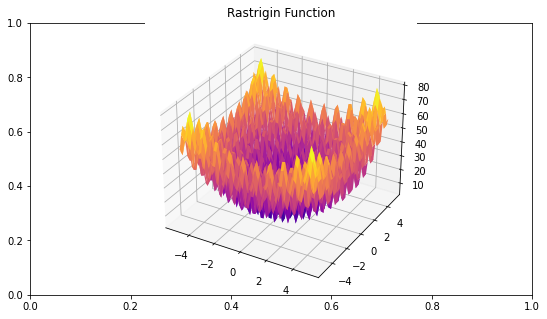

In [422]:
Plot_func(Rastrigin_func,-5.12,5.12,-5.12,5.12,"Rastrigin Function");

target global min= 0.00  at  (0,0)
result global min= 0.0  at  [0. 0.]


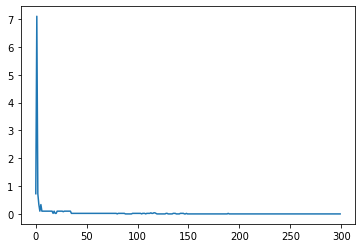

In [125]:
#Find the global minima of the Rastrigin function N.13
GA_Find_GlobalMinima(Rastrigin_func,1000,-6,6,100,300,0.99,0.05,"{:0.2f}".format(Rastrigin_func(0,0)),
                     "(0,0)");

<hr/>
<h3>Schaffer Function N.2</h3>
<p>$f(x)=0.5+\large\frac{\sin^2(x_1^2-x_2^2)-0.5}{[1+0.001(x_1^2+x_2^2)]^2}$</p>
<p>Domain $x_i\in[-100,100]$ for all $i=1,2$</p>
<p>Global Minimum</p>
<p>$f(x^*)=0$ at $x^*=(0,0)$</p>

In [126]:
def Schaffer_funcN2(x,y):
    return 0.5+((np.sin(x**2+y**2))**2-0.5)/(1+0.001*(x**2+y**2))**2;

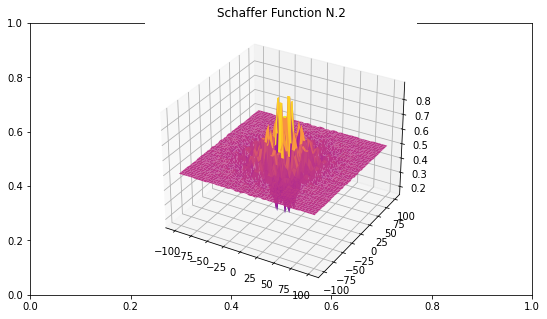

In [423]:
Plot_func(Schaffer_funcN2,-100,100,-100,100,"Schaffer Function N.2");

target global min= 0.00  at  (0,0)
result global min= 0.003956659749728975  at  [1.1 1.4]


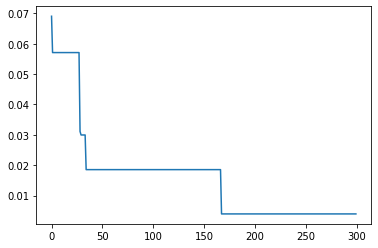

In [141]:
#Find the global minima of the Schaffer function N.2
GA_Find_GlobalMinima(Schaffer_funcN2,1000,-100,100,10,300,0.99,0.05,"{:0.2f}".format(Schaffer_funcN2(0,0)),
                     "(0,0)");

<hr/>
<h3>Schaffer Function N.4</h3>
<p>$f(x)=0.5+\large\frac{\cos^2\left(\sin(|x_1^2-x_2^2|)\right)-0.5}{\left[1+0.001(x_1^2+x_2^2)\right]^2}$</p>
<p>Domain $x_i\in[-100,100]$ for all $i=1,2$</p>

In [143]:
def Schaffer_funcN4(x,y):
    return 0.5+((np.cos(np.sin(np.abs(x**2+y**2))))**2-0.5)/((1+0.001*(x**2+y**2))**2);

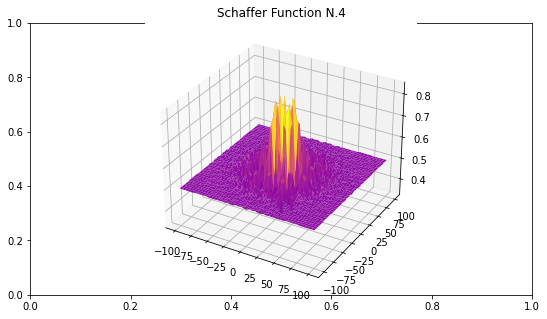

In [424]:
Plot_func(Schaffer_funcN4,-100,100,-100,100,"Schaffer Function N.4");

target global min= unknown  at  unknown
result global min= 0.2981769629274056  at  [ 2.4 -2.9]


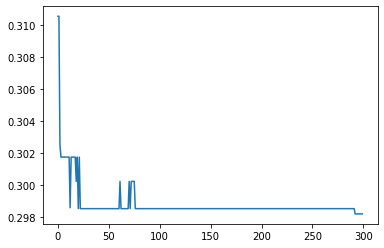

In [145]:
#Find the global minima of the Schaffer function N.4
GA_Find_GlobalMinima(Schaffer_funcN4,1000,-100,100,10,300,0.99,0.05,"unknown","unknown");

<h3>Schwefel Function</h3>
<p>$f(x)=418.9829d-\sum\limits_{i=1}^d{x_i\sin(\sqrt{|x_i|})}$</p>
<p>For 2D<br/>
    $f(x)=837.9658-x\sin(\sqrt{|x|}-y\sin(\sqrt{|y|})$</p>
<p>Domain $x_i\in[-500,500]$ for all $i=1,..,d$</p>
<p>Global Minimum</p>
<p>$f(x^*)=0$ at $x^*=(420.9687,...,420.9687)$</p>

In [149]:
def Schwefel_func(x,y):
    return 837.9658-x*np.sin(np.sqrt(np.abs(x)))-y*np.sin(np.sqrt(np.abs(y)));

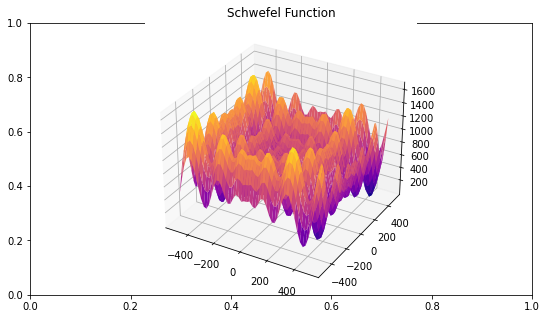

In [425]:
Plot_func(Schwefel_func,-500,500,-500,500,"Schwefel Function");

target global min= 0.00  at  (420.9687,420.9687)
result global min= 434.7439728195976  at  [205.51 204.69]


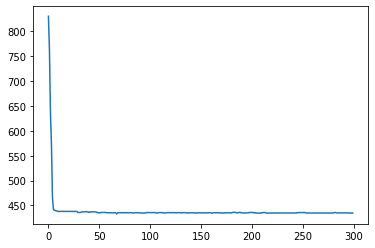

In [152]:
#Find the global minima of the Schwefel function
GA_Find_GlobalMinima(Schwefel_func,1000,-500,500,100,300,0.99,0.05,"{:0.2f}".format(Schwefel_func(420.9687,420.9687)),"(420.9687,420.9687)");

<hr/>
<h3>Shubert Function</h3>
<p>$f(x)=\left(\sum\limits_{i=1}^{5}{i\cos\left((i+1)x_1+i\right)}\right)\left(\sum\limits_{i=1}^5{i\cos\left((i+1)x_2+i\right)}\right)$</p>
<p>Domain $x_i\in[-10,10]$ for all $i=1,2$ although this may be restricted to $x_i\in[-5.12,5.12]$ for all $i=1,2$</p>
<p>Global minimum</p>
<p>$f(x^*)=-186.7309$</p>

In [153]:
def Shubert_func(x,y):
    px=0;py=0;
    for i in range(5):
        px+=(i*np.cos((i+1)*x+i));
        py+=(i*np.cos((i+1)*y+i));
    return px*py;

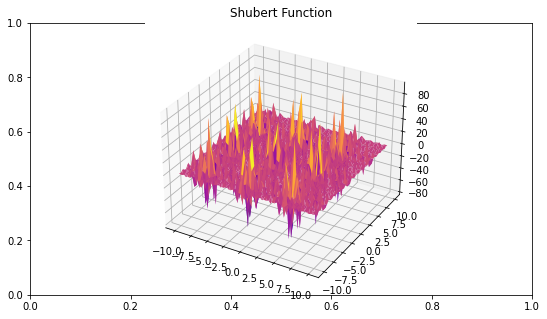

In [426]:
Plot_func(Shubert_func,-10,10,-10,10,"Shubert Function");

target global min= −186.7309  at  unknown
result global min= -80.66626059171594  at  [5.46 4.83]


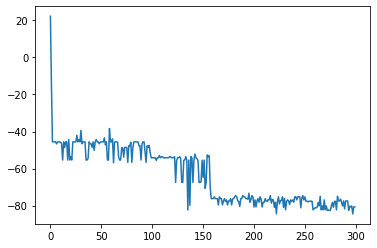

In [155]:
#Find the global minima of the Shubert function
GA_Find_GlobalMinima(Shubert_func,1000,-10,10,100,300,0.99,0.05,"−186.7309","unknown");

<hr/>
<h3>Bohachevsky Function</h3>
<p>$f_1(x)=x_1^2+2x_2^2-0.3\cos(3\pi x_1)-0.4\cos(4\pi x_2)+0.7$</p>
<p>$f_2(x)=x_1^2+2x_2^2-0.3\cos(3\pi x_1)\cos(4\pi x_2)+0.3$</p>
<p>$f_3(x)=x_1^2+2x_2^2-0.3\cos(3\pi x_1+4\pi x_2)+0.3$</p>
<p>These all have the same similar bowl shape</p>
<p>Domain $x_i\in[-100,100]$ for all $i=1,2$</p>
<p>Global Minimum</p>
<p>$f_j(x^*)=0$ at $x^*=(0,0)$ for all $j=1,2,3$</p>

In [160]:
def Bohachevsky_func(x,y):
    #return x**2+y**2-0.3*np.cos(3*np.pi*x)-0.4*np.cos(4*np.pi*y)+0.7;
    #return x**2+y**2-0.3*np.cos(3*np.pi*x)*np.cos(4*np.pi*y)+0.3;
    return x**2+y**2-0.3*np.cos(3*np.pi*x+4*np.pi*y)+0.3;

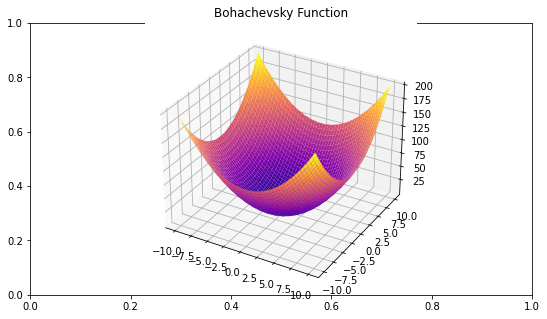

In [427]:
Plot_func(Bohachevsky_func,-10,10,-10,10,"Bohachevsky Function");

target global min= 0.0  at  (0,0)
result global min= 0.03468304511145398  at  [-0.1  0.1]


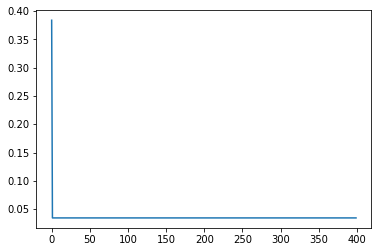

In [190]:
#Find the global minima of the Bohachevsky function
GA_Find_GlobalMinima(Bohachevsky_func,1000,-10,10,10,400,0.99,0.06,Bohachevsky_func(0,0),"(0,0)");

<hr/>
<h3>Perm Function 0,D,Beta</h3>
<p>$f(x)=\sum\limits_{i=1}^d{\left(\sum\limits_{j=1}^d{(j+\beta)\left(x_j^i-\frac{1}{j^i}\right)}\right)^2}$</p>
<p>Beta-> optional constant, with default value of 10</p>
<p>So for 2D (i.e. d=2)<br/>
$f(x)=\left((1+\beta)\left(x-1\right)+(2+\beta)\left(y-\frac{1}{2}\right)\right)^2+\left((1+\beta)\left(x^2-1\right)+(2+\beta)\left(y^2-\frac{1}{4}\right)\right)^2$</p>
<p>Domain $x_i\in[-d,d]$ for all $i=1,...d$</p>
<p>Global Minimum</p>
<p>$f(x^*)=0$ at $x^*=(1,\frac{1}{2},...,\frac{1}{d})$</p>

In [369]:
def Perm0_func(x,y):
    beta=10;
    return ((1+beta)*(x-1)+(2+beta)*(y-.5))**2+((1+beta)*(x**2-1)+(2+beta)*(y**2-.25))**2;

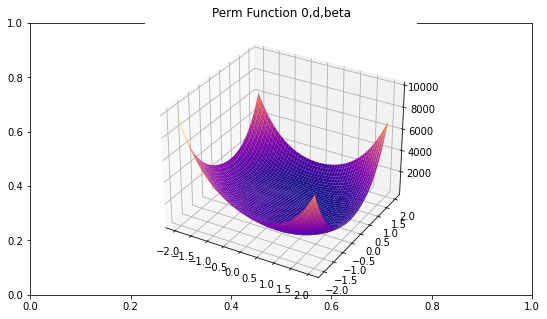

In [428]:
Plot_func(Perm0_func,-2,2,-2,2,"Perm Function 0,d,beta");

target global min= 0.0  at  (1,0.5)
result global min= 0.0  at  [1.  0.5]


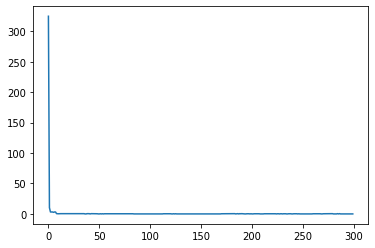

In [371]:
#Find the global minima of the Perm function
GA_Find_GlobalMinima(Perm0_func,1000,-2,2,10,300,0.99,0.06,Perm0_func(1,.5),"(1,0.5)");

<hr/>
<h3>Rotated Hyper-Ellipsoid Function</h3>
<p>$f(x)=\sum\limits_{i=1}^{d}{\sum\limits_{j=1}^i{x_j^2}}$</p>
<p>So, for 2D<br/>
    $f(x,y)=2x^2+y^2$</p>
<p>Domain $x_i\in[-65.536,65.536]$ for all $i=1,..,d$</p>
<p>Global Minimum</p>
<p>$f(x^*)=0$ at $x^*=(0,....,0)$</p>

In [189]:
def Rotated_Hyper_Ellipsoid_func(x,y):
    return 2*x**2+y**2;

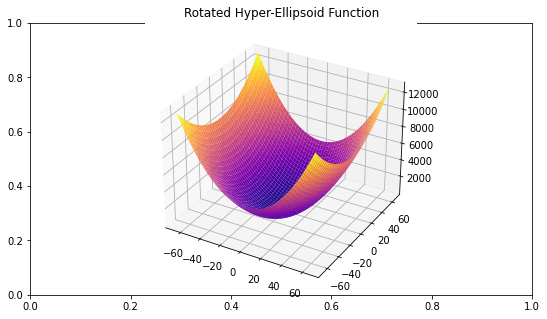

In [429]:
Plot_func(Rotated_Hyper_Ellipsoid_func,-65.536,65.536,-65.536,65.536,"Rotated Hyper-Ellipsoid Function");

target global min= 0  at  (0,0)
result global min= 8e-06  at  [0.002 0.   ]


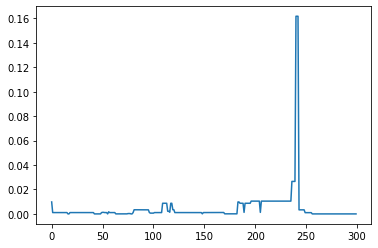

In [193]:
#Find the global minima of the Rotated Hyper-Ellipsoid  function
GA_Find_GlobalMinima(Rotated_Hyper_Ellipsoid_func,1000,-66,66,1000,300,0.99,0.06,Rotated_Hyper_Ellipsoid_func(0,0),"(0,0)");

<hr/>
<h3>Sphere Function</h3>
<p>$f(x)=\sum\limits_{i=1}^d{x_i^2}$</p>
<p>So for 2D<br/>
    $f(x,y)=x^2+y^2$</p>
<p>Domain $x_i\in[-5.12,5.12]$ for all $i=1,..d$</p>
<p>Global Minimum</p>
<p>$f(x^*)=0$ at $x^*=(0,...,0)$</p>

In [194]:
def Sphere_func(x,y):
    return x**2+y**2;

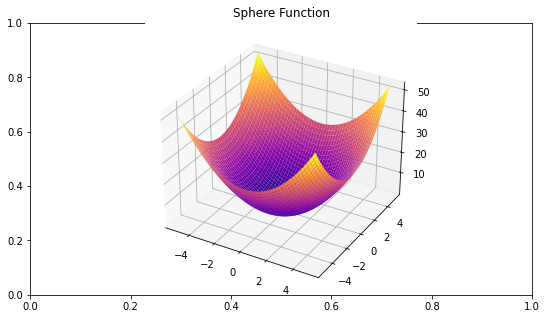

In [430]:
Plot_func(Sphere_func,-5.12,5.12,-5.12,5.12,"Sphere Function");

target global min= 0  at  (0,0)
result global min= 0.005218  at  [0.027 0.067]


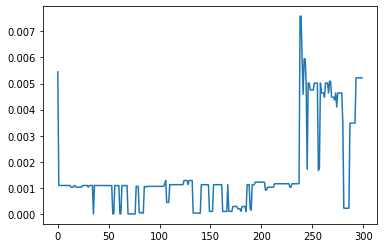

In [201]:
#Find the global minima of the Sphere function
GA_Find_GlobalMinima(Sphere_func,1300,-66,66,1000,300,0.99,0.06,Sphere_func(0,0),"(0,0)");

<hr/>
<h3>Sum of Different Powers Function</h3>
<p>$f(x)=\sum\limits_{i=1}^d{|x_i|^{i+1}}$</p>
<p>So for 2D<br/>
    $f(x,y)=|x|^2+|y|^3$</p>
<p>Domain $x_i=[-1,1]$ for all $i=1,...,d$</p>
<p>Global Minimum</p>
<p>$f(x^*)=0$ at $x^*=(0,...,0)$</p>

In [200]:
def Sum_of_Different_Powers_func(x,y):
    return np.abs(x)**2+np.abs(y)**3;

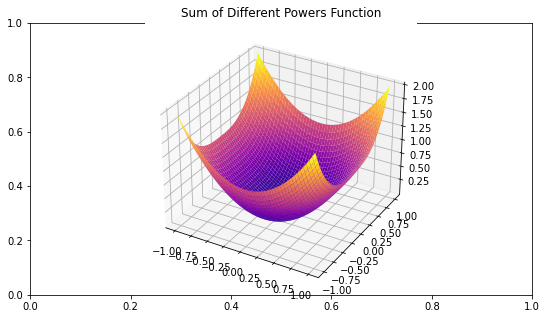

In [431]:
Plot_func(Sum_of_Different_Powers_func,-1,1,-1,1,"Sum of Different Powers Function");

target global min= 0  at  (0,0)
result global min= 5.165299999999999e-05  at  [ 0.001 -0.037]


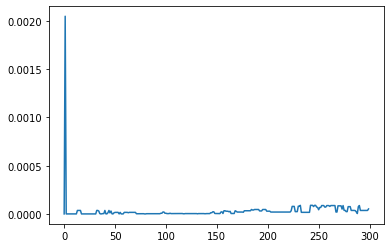

In [203]:
#Find the global minima of the Sum of Different Powers function
GA_Find_GlobalMinima(Sum_of_Different_Powers_func,1000,-1,1,1000,300,0.99,0.06,Sum_of_Different_Powers_func(0,0),"(0,0)");

<hr/>
<h3>Sum Squares Function</h3>
<p>$f(x)=\sum\limits_{i=1}^d{ix_i^2}$</p>
<p>So, for 2D:<br/>
    $f(x,y)=x^2+2y^2$</p>
<p>Domain $x_i\in[-10,10]$ for all $i=1,..,d$, although it may be restricted to $x_i\in[-5.12,5.12]$ for all $i=1,..,d$</p>
<p>Global Minimum</p>
<p>$f(x^*)=0$ at $x^*=(0,..,0)$</p>

In [204]:
def Sum_Squares_func(x,y):
    return x**2+2*y**2;

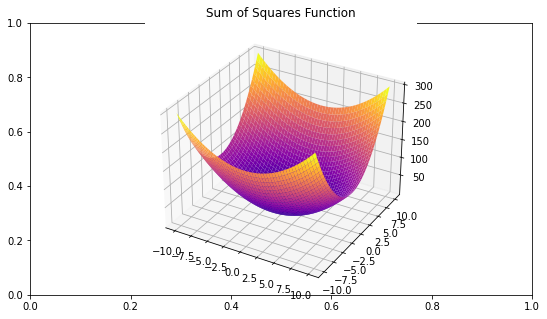

In [432]:
Plot_func(Sum_Squares_func,-10,10,-10,10,"Sum of Squares Function");

target global min= 0  at  (0,0)
result global min= 0.0011  at  [-0.03 -0.01]


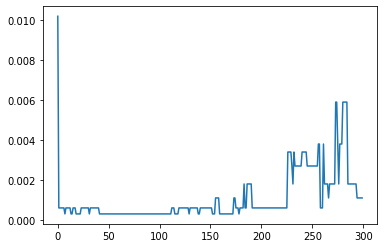

In [206]:
#Find the global minima of the Sum of Squares function
GA_Find_GlobalMinima(Sum_Squares_func,1000,-10,10,100,300,0.99,0.06,Sum_Squares_func(0,0),"(0,0)");

<hr/>
<h3>Trid Function</h3>
<p>$f(x)=\sum\limits_{i=1}^d{(x_i-1)^2-\sum\limits_{i=2}^d{x_ix_{i-1}}}$</p>
<p>So, for 2D<br/>
    $f(x,y)=(x-1)^2+(y-1)^2-xy$</p>
<p>Domain $x_i\in[-d^2,d^2]$ for all $i=1,..,d$</p>
<p>Global Minimum</p>
<p>$f(x^*)=-d(d+4)(d-1)/6$ at $x_i=i(d+1-i)$ for all $i=1,..,d$</p>
<p>for 2D<br/>
    $f(x^*,y^*)=-2$ at $x=2,y=2$ for all $i=1,..,d$</p>

In [209]:
def Trid_func(x,y):
    return (x-1)**2+(y-1)**2-x*y;

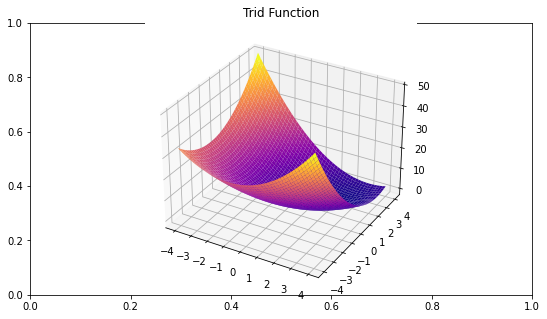

In [433]:
Plot_func(Trid_func,-4,4,-4,4,"Trid Function");

target global min= -2  at  (2,2)
result global min= -1.9799  at  [1.95 1.84]


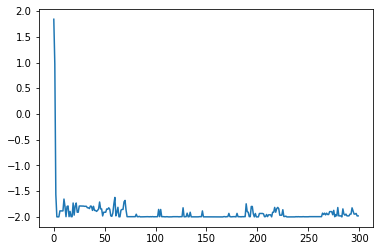

In [211]:
#Find the global minima of the Trid function
GA_Find_GlobalMinima(Trid_func,1000,-4,4,100,300,0.99,0.06,Trid_func(2,2),"(2,2)");

<hr/>
<h3>Booth Function</h3>
<p>$f(x)=(x_1+2x_2-7)^2+(2x_1+x_2-5)^2$</p>
<p>Domain $x_i\in[-10,10]$ for all $i=1,2$</p>
<p>Global Minimum</p>
<p>$f(x^*)=0$ at $x^*=(1,3)$</p>

In [212]:
def Booth_func(x,y):
    return (x+2*y-7)**2+(2*x+y-5)**2;

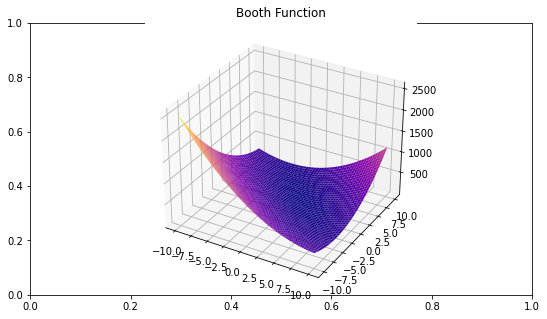

In [434]:
Plot_func(Booth_func,-10,10,-10,10,"Booth Function");

target global min= 0  at  (1,3)
result global min= 0.004500000000000075  at  [1.05 2.96]


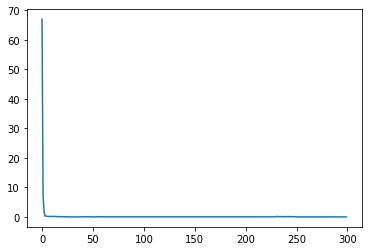

In [215]:
#Find the global minima of the Booth function
GA_Find_GlobalMinima(Booth_func,1000,-10,10,100,300,0.99,0.06,Booth_func(1,3),"(1,3)");

<hr/>
<h3>Matyas Function</h3>
<p>$f(x)=0.26(x_1^2+x_2^2)-0.48x_1x_2$</p>
<p>Domain $x_i\in[-10,10]$ for all $i=1,2$</p>
<p>Global Minimum</p>
<p>$f(x^*)=0$ at $x^*=(0,0)$</p>

In [216]:
def Matyas_func(x,y):
    return 0.26*(x**2+y**2)-0.48*x*y;

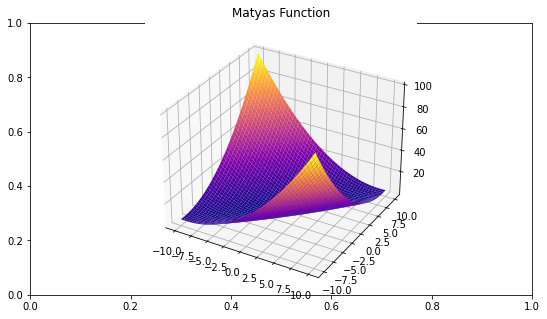

In [435]:
Plot_func(Matyas_func,-10,10,-10,10,"Matyas Function");

target global min= 0.0  at  (0,0)
result global min= 0.0001360000000000001  at  [-0.02 -0.04]


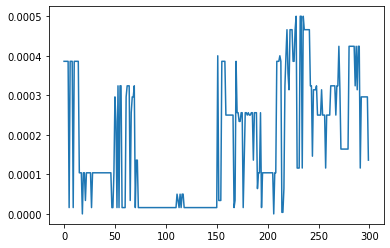

In [218]:
#Find the global minima of the Matyas function
GA_Find_GlobalMinima(Matyas_func,1000,-10,10,100,300,0.99,0.06,Matyas_func(0,0),"(0,0)");

<hr/>
<h3>McCormick Function</h3>
<p>$f(x)=\sin(x_1+x_2)+(x_1-x_2)^2-1.5x_1+2.5x_2+1$</p>
<p>Domain $x_1\in[-1.5,4] x_2\in[-3,4]$</p>
<p>Global Minimum</p>
<p>$f(x^*)=-1.9133$ at $x^*=(-0.54719,-1.54719)$</p>

In [219]:
def McCormick_func(x,y):
    return np.sin(x+y)+(x-y)**2-1.5*x+2.5*y+1;

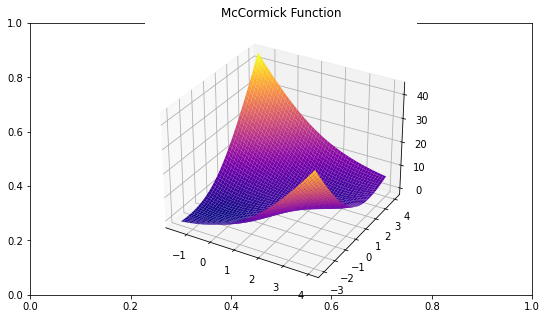

In [436]:
Plot_func(McCormick_func,-1.5,4,-3,4,"McCormick Function");

target global min= -1.913222954882274  at  (−0.54719,−1.54719)
result global min= -4.327337793018005  at  [-3.31  -3.949]


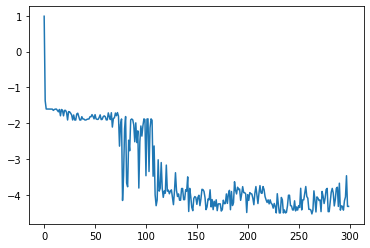

In [226]:
#Find the global minima of the McCormick function
GA_Find_GlobalMinima(McCormick_func,1000,-3,4,1000,300,0.3,0.1,McCormick_func(-0.54719,-1.54719),"(−0.54719,−1.54719)");

<hr/>
<h3>Power Sum Function</h3>
<p>$f(x)=\sum\limits_{i=1}^d{\left[\left(\sum\limits_{j=1}^d{x_j^i}\right)-b_i\right]^2}$</p>
<p>if $d=4$ $b=(8,18,44,114)$</p>
<p>So, for 2D<br/>
    $f(x,y)=\left[x+y-8\right]^2+\left[x^2+y^2-18\right]^2$</p>
<p>Domain $x_i\in[0,d]$ for all $i=1,..d$</p>

In [227]:
def Power_Sum_func(x,y):
    return (x+y-8)**2+(x**2+y**2-18)**2;

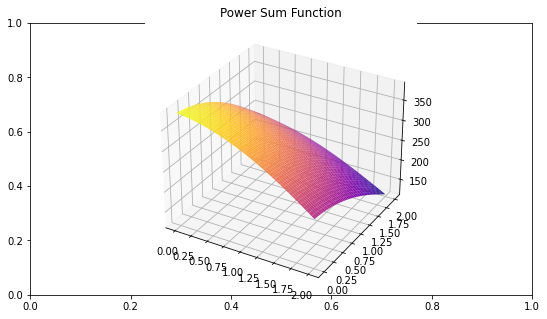

In [437]:
Plot_func(Power_Sum_func,0,2,0,2,"Power Sum Function");

target global min= unknown  at  Unknown
result global min= 248.08858564000002  at  [1.27 1.27]


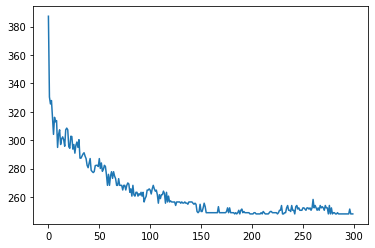

In [230]:
#Find the global minima of the Power Sum function
GA_Find_GlobalMinima(Power_Sum_func,1000,0,2,100,300,0.3,0.1,"unknown","Unknown");

<hr/>
<h3>Zakharov Function</h3>
<p>$f(x)=\sum\limits_{i=1}^d{x_i^2}+\left(\sum\limits_{i=1}^d{0.5ix_i}\right)^2+\left(\sum\limits_{i=1}^d{0.5ix_i}\right)^4$</p>
<p>So for 2D<br/>
  $f(x,y)=x^2+y^2+(0.5x+y)^2+(0.5x+y)^4$</p>
<p>Domain $x_i\in[-5,10]$ for all $i=1,..d$</p>
<p>Global Minimum</p>
<p>$f(x^*)=0$ at $x^*=(0,...,0)$</p>

In [231]:
def Zakharov_func(x,y):
    return x**2+y**2+(0.5*x+y)**2+(0.5*x+y)**4;

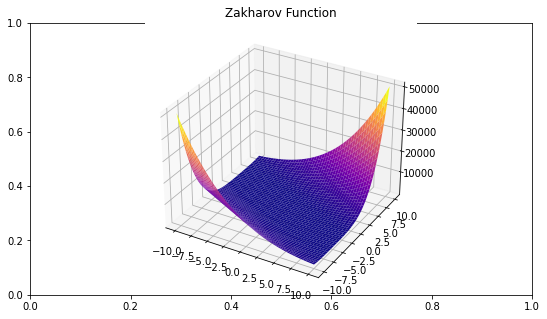

In [438]:
Plot_func(Zakharov_func,-10,10,-10,10,"Zakharov Function");

target global min= 0.0  at  (0,0)
result global min= 0.007326500625  at  [ 0.05 -0.06]


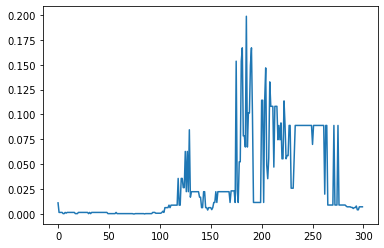

In [238]:
#Find the global minima of the Zakharov function
GA_Find_GlobalMinima(Zakharov_func,1000,-10,10,100,300,0.99,0.1,Zakharov_func(0,0),"(0,0)");

<hr/>
<h3>Three-Hump Camel Function</h3>
<p>$f(x)=2x_1^2-1.05x_1^4+\frac{x_1^6}{6}+x_1x_2+x_2^2$</p>
<p>Domain $x_i\in[-5,5]$ for all $i=1,2$</p>
<p>Global Minimum</p>
<p>$f(x^*)=0$ at $x^*=(0,0)$</p>

In [239]:
def Three_Hump_Camel_func(x,y):
    return 2*x**2-1.05*(x**4)+(x**6)/6+x*y+y**2;

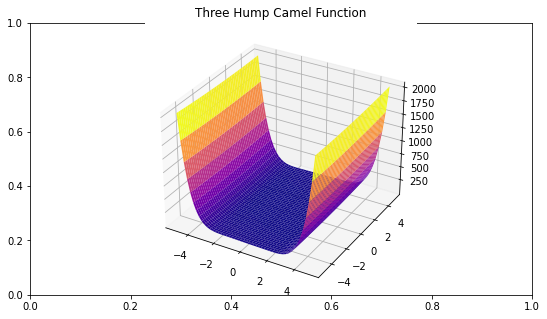

In [439]:
Plot_func(Three_Hump_Camel_func,-5,5,-5,5,"Three Hump Camel Function");

target global min= 0.0  at  (0,0)
result global min= 0.0015991496215  at  [ 0.03 -0.02]


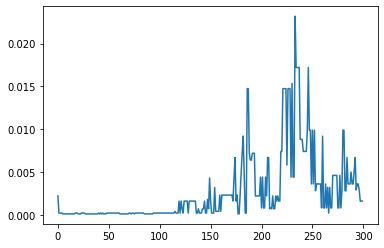

In [240]:
#Find the global minima of the Three Hump Camel function
GA_Find_GlobalMinima(Three_Hump_Camel_func,1000,-5,5,100,300,0.99,0.1,Three_Hump_Camel_func(0,0),"(0,0)");

<hr/>
<h3>Six-hump Camel Function</h3>
<p>$f(x)=\left(4-2.1x_1^2+\frac{x_1^4}{3}\right)x_1^2+x_1x_2+(-4+4x_2^2)x_2^2$</p>
<p>Domain $x_1\in[-3,3],x_2\in[-2,2]$</p>
<p>Global Minimum</p>
<p>$f(x^*)=-1.0316$ at $x^*=(0.0898,-0.7126)$ and $(-0.0898,0.7126)$</p>

In [242]:
def Six_Hump_Camel_func(x,y):
    return (4-2.1*(x**2)+(x**4)/3)*(x**2)+x*y+(-4+4*y*y)*(y**2);

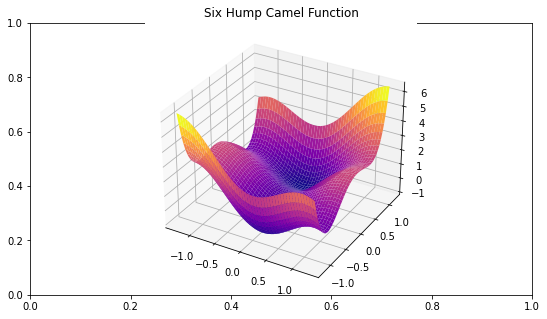

In [440]:
Plot_func(Six_Hump_Camel_func,-1.3,1.3,-1.2,1.2,"Six Hump Camel Function");

target global min= -1.0316284229280819  at  (0.0898,−0.7126) and (−0.0898,0.7126)
result global min= -1.018779420672  at  [ 0.12 -0.68]


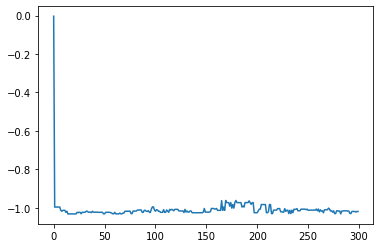

In [249]:
#Find the global minima of the Six Hump Camel function
GA_Find_GlobalMinima(Six_Hump_Camel_func,1000,-3,3,100,300,0.99,0.1,Six_Hump_Camel_func(0.0898,-0.7126),"(0.0898,−0.7126) and (−0.0898,0.7126)");

<hr/>
<h3>Dixon-price Function</h3>
<p>$f(x)=(x_1-1)^2+\sum\limits_{i=2}^d{i(2x_i^2-x_{i-1})^2}$</p>
<p>So for 2D<br/>
    $f(x,y)=(x-1)^2+2(2y^2-x)^2$</p>
<p>Domain $x_i\in[-10,10]$ for all $i=1,..d$</p>
<p>Global Minimum</p>
<p>$f(x^*)=0$ at $x_i=2^{-\frac{2^i-2}{2^i}}$ for $i=1,..d$</p>
<p>So, for 2D<br/>
    $f(x^*)=0$ at $x=1,y=0.7071$</p>

In [251]:
def Dixon_price_func(x,y):
    return (x-1)**2+(2*(2*y**2-x)**2);

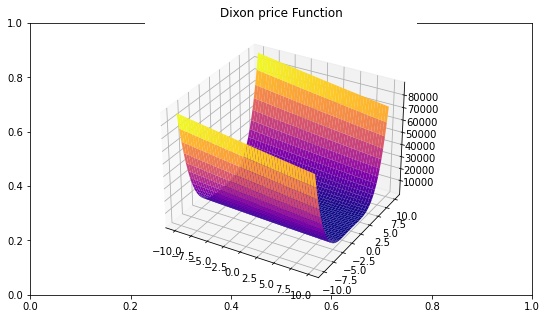

In [441]:
Plot_func(Dixon_price_func,-10,10,-10,10,"Dixon price Function");

target global min= 0.00  at  (1,0.7071)
result global min= 0.022340480000000006  at  [ 0.94 -0.72]


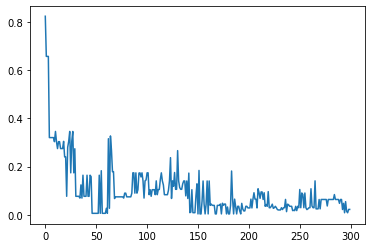

In [257]:
#Find the global minima of the Dixon price function
GA_Find_GlobalMinima(Dixon_price_func,1000,-10,10,100,300,0.99,0.1,"{:0.2f}".format(Dixon_price_func(1,0.7071)),"(1,0.7071)");

<hr/>
<h3>Rosenbrock Function</h3>
<p>$f(x)=\sum\limits_{i=1}^{d-1}{[100(x_{i+1}-x_i^2)^2+(x_i-1)^2]}$</p>
<p>So, for 2D <br/>
    $f(x,y)=100(y-x^2)^2+(x-1)^2$</p>
<p>Domain $x_i\in[-5,10]$ for all $i=1,..d$ although it may be restricted to $x_i\in[-2.048,2.048]$ for all $i=1,..d$</p>
<p>Global Minimum</p>
<p>$f(x^*)=0$ at $x^*=(1,...,1)$</p>

In [258]:
def Rosenbrock_func(x,y):
    return 100*(y-x**2)**2+(x-1)**2;

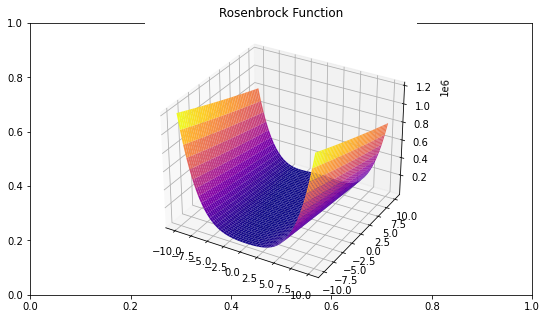

In [442]:
Plot_func(Rosenbrock_func,-10,10,-10,10,"Rosenbrock Function");

target global min= 0.00  at  (1,1)
result global min= 0.34950100000000023  at  [0.49 0.27]


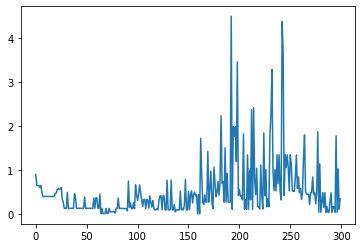

In [263]:
#Find the global minima of the Rosenbrock function
GA_Find_GlobalMinima(Rosenbrock_func,1000,-10,10,100,300,0.4,0.1,"{:0.2f}".format(Rosenbrock_func(1,1)),"(1,1)");

<hr/>
<h3>de Jong Function</h3>
<p>$f(x)=\left(0.002+\sum\limits_{i=1}^{25}{\frac{1}{i+(x_1-a_{1i})^6+(x_2-a_{2i})^6}}\right)^{-1}$</p>
<p> $a=\begin{pmatrix}
-32 & -16 &0 &16 &32 &-32 &...&0&16&32\\
-32 & -32&-32&-32&-32&-16&...&32&32&32\\
\end{pmatrix}$</p>
<p>Domain $x_i\in[-65.536,65.536]$ for all $i=1,2$</p>


In [266]:
def deJong_func(x,y):
    a=[[-32,-16,0,16,32, -32,-16,0,16,32, -32,-16,0,16,32, -32,-16,0,16,32, -32,-16,0,16,32],
      [-32,-32,-32,-32,-32, -16,-16,-16,-16,-16, 0,0,0,0,0, 16,16,16,16,16, 32,32,32,32,32]];
    result=0.002;
    for i in range(25):
        result+=(1/(i+(x-a[0][i])**6+(y-a[1][i])**6));        
    return 1/result;

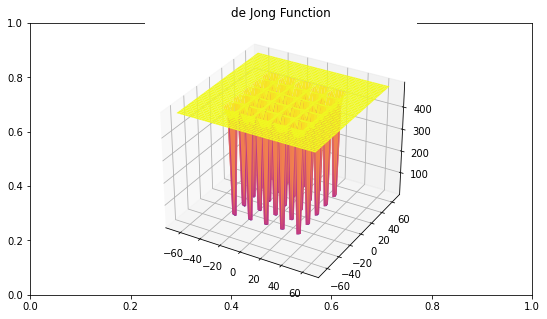

In [443]:
Plot_func(deJong_func,-65.536,65.536,-65.536,65.536,"de Jong Function");

target global min= unknown  at  unknown
result global min= 10.778823318292241  at  [-16.3   0.5]


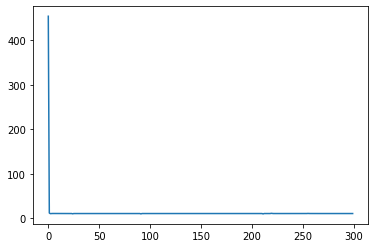

In [269]:
#Find the global minima of the de Jong function
GA_Find_GlobalMinima(deJong_func,1000,-66,66,10,300,0.4,0.1,"unknown","unknown");

<hr/>
<h3>Easom Function</h3>
<p>$f(x)=-\cos(x_1)\cos(x_2)\exp(-(x_1-\pi)^2-(x_2-\pi)^2)$</p>
<p>Domain $x_i\in[-100,100]$ for all $i=1,2$</p>
<p>Global Minimum</p>
<p>$f(x^*)=-1$ at $x^*=(\pi,\pi)$</p>

In [273]:
def Easom_func(x,y):
    return -np.cos(x)*np.cos(y)*np.exp(-(x-math.pi)**2-(y-math.pi)**2);

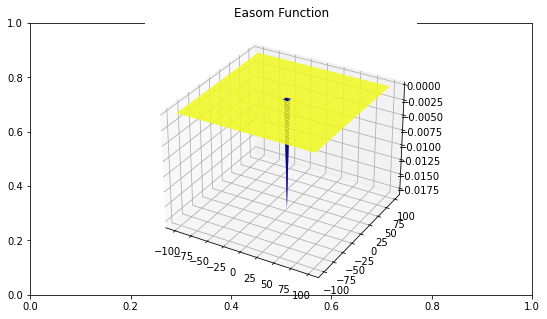

In [444]:
Plot_func(Easom_func,-100,100,-100,100,"Easom Function");

target global min= -1.0  at  (𝜋,𝜋)
result global min= -0.41698766624355943  at  [2.42 2.93]


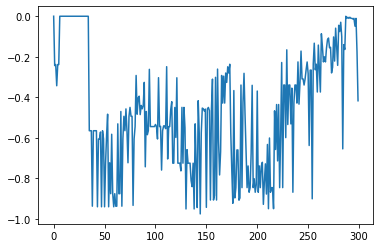

In [286]:
#Find the global minima of the Easom  function
GA_Find_GlobalMinima(Easom_func,1000,-10,10,100,300,0.99,0.06,Easom_func(math.pi,math.pi),"(𝜋,𝜋)");

<hr/>
<h3>Michalewicz Function</h3>
<p>$f(x)=-\sum\limits_{i=1}^d{\sin(x_i)\sin^{2m}\left(\frac{ix_i^2}{\pi}\right)}$</p>
<p>$m=10$</p>
<p>So, for 2D<br/>
    $f(x)=-\sin(x)\sin^{20}\left(\frac{x^2}{\pi}\right)-\sin(y)\sin^{20}\left(\frac{2y^2}{\pi}\right)$</p>
<p>Domain $x_i\in[0,\pi]$ for all $i=1,..,d$</p>
<p>Global Minimum</p>
<p>at $d=2:f(x^*)=-1.8013$ at $x^*=(2.20,1.57)$</p>
<p>at $d=5:f(x^*)=-4.687658$</p>
<p>at $d=10:f(x^*)=-9.66015$</p>

In [282]:
def Michalewicz_func(x,y):
    return -np.sin(x)*(np.sin(x**2/np.pi))**20-np.sin(y)*(np.sin(2*y**2/np.pi)**20);

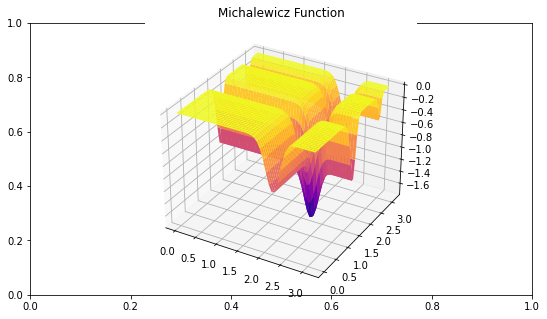

In [445]:
Plot_func(Michalewicz_func,0,3.14,0,3.14,"Michalewicz Function");

target global min= -1.801140718473825  at  (2.20,1.57)
result global min= -1.78147234414676  at  [2.19 1.55]


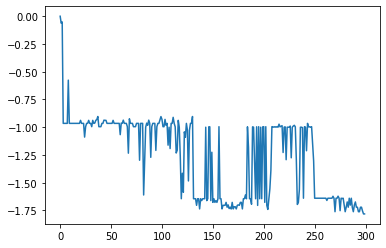

In [288]:
#Find the global minima of the Michalewicz  function
GA_Find_GlobalMinima(Michalewicz_func,1000,0,4,100,300,0.99,0.06,Michalewicz_func(2.20,1.57),"(2.20,1.57)");

<hr/>
<h3>Beale Function</h3>
<p>$f(x)=(1.5-x_1+x_1x_2)^2+(2.25-x_1+x_1x_2^2)^2+(2.625-x_1+x_1x_2^3)^2$</p>
<p>Domain $x_i\in[-4.5,4.5]$ for all $i=1,2$</p>
<p>Global Minimum</p>
<p>$f(x^*)=0$ at $x^*=(3,0.5)$</p>

In [289]:
def Beale_func(x,y):
    return (1.5-x+x*y)**2+(2.25-x+x*(y**2))**2+(2.625-x+x*(y**3))**2;

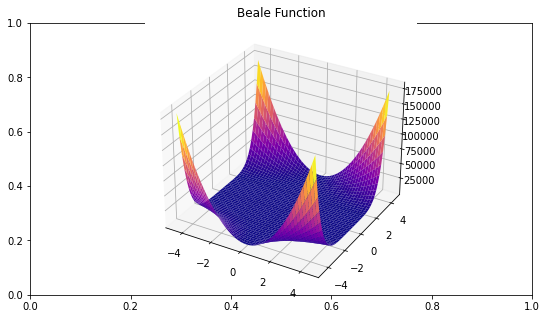

In [446]:
Plot_func(Beale_func,-4.5,4.5,-4.5,4.5,"Beale Function");

target global min= 0.0  at  (3,0.5)
result global min= 0.009523317385318393  at  [2.83 0.44]


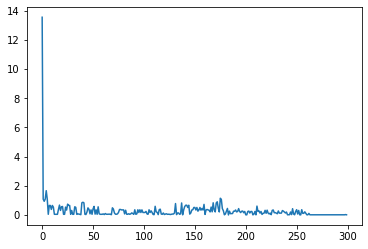

In [294]:
#Find the global minima of the Beale function
GA_Find_GlobalMinima(Beale_func,1000,-5,5,100,300,0.3,0.06,Beale_func(3,0.5),"(3,0.5)");

<hr/>
<h3>Branin Function</h3>
<p>$f(x)=a(x_2-bx_1^2+cx_1-r)^2+s(1-t)\cos(x_1)+s$</p>
<p>$a=1,b=\frac{5.1}{4\pi^2},c=\frac{5}{\pi},r=6,s=10$ and $t=\frac{1}{8\pi}$</p>
<p>Domain $x_1\in[-5,10],x_2\in[0,15]$</p>
<p>Global Minimum</p>
<p>$f(x^*)=0.387887$ at $x^*=(-\pi,12.275),(\pi,2.275)$ and $(9.42478,2.475)$</p>

In [298]:
def Branin_func(x,y):
    a=1;b=5.1/(4*(math.pi**2));
    c=5/math.pi;
    r=6;s=10;t=1/(8*math.pi);
    return a*(y-b*(x**2)+c*x-r)**2+s*(1-t)*np.cos(x)+s;

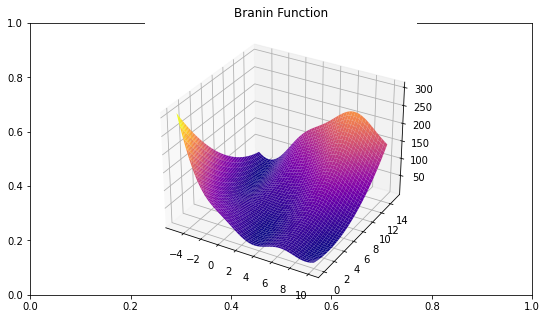

In [447]:
Plot_func(Branin_func,-5,10,0,15,"Branin Function");

target global min= 0.39788735775266204  at  (9.42478,2.475)
result global min= 0.535918263630732  at  [9.27 2.5 ]


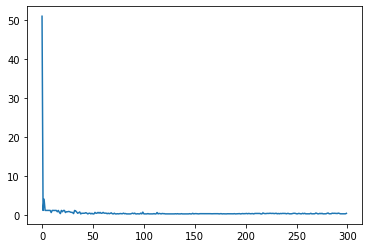

In [300]:
#Find the global minima of the Branin function
GA_Find_GlobalMinima(Branin_func,1000,-5,15,100,300,0.3,0.06,Branin_func(9.42478,2.475),"(9.42478,2.475)");

<hr/>
<h3>Colville Function</h3>
<p>$f(x)=100(x_1^2-x_2)^2+(x_1-1)^2+(x_3-1)^2+90(x_3^2-x_4)^2+10.1((x_2-1)^2+(x_4-1)^2)+19.8(x_2-1)(x_4-1)$</p>
<p>So, if I reduce it to 2D <br/>
    $f(x,y)=100(x^2-y)^2+(x-1)^2+10.1(y-1)^2$</p>
<p>Domain $x_i\in[-10,10]$ for all $i=1,2,3,4$</p>
<p>Global Minimum</p>
<p>$f(x^*)=0$ at $x^*=(1,1,1,1)$</p>

In [317]:
def Colville_func(x,y):
    return 100*((x**2-y)**2)+(x-1)**2+10.1*((y-1)**2);

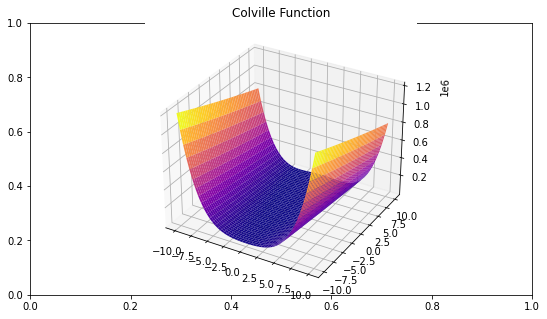

In [448]:
Plot_func(Colville_func,-10,10,-10,10,"Colville Function");

target global min= 0.0  at  (1,1)
result global min= 0.8431509999999993  at  [0.87 0.83]


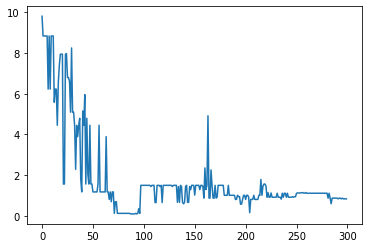

In [319]:
#Find the global minima of the Colville function
GA_Find_GlobalMinima(Colville_func,1000,-10,10,100,300,0.3,0.06,Colville_func(1,1),"(1,1)");

<hr/>
<h3>Forrester et al 2008 Function</h3>
<p>$f(x)=(6x-2)^2\sin(12x-4)$</p>
<p>Domain $x\in[0,1]$</p>


In [322]:
def Forrester_func(x,y):
    return ((6*x-2)**2)*np.sin(12*x-4);

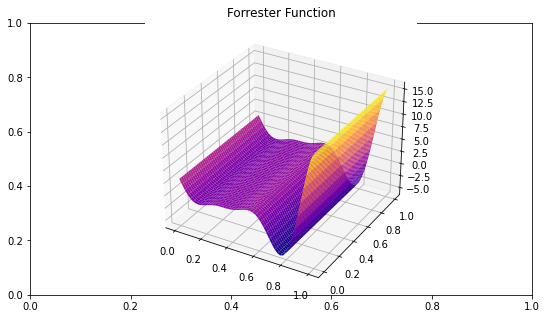

In [449]:
Plot_func(Forrester_func,0,1,0,1,"Forrester Function");

target global min= unknown  at  unknown
result global min= -15.906482916772706  at  [-0.34  0.2 ]


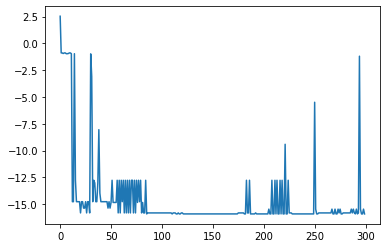

In [324]:
#Find the global minima of the Forrester function
GA_Find_GlobalMinima(Forrester_func,1000,0,1,100,300,0.3,0.06,"unknown","unknown");

<hr/>
<h3>Goldstein-price Function</h3>
<p>$f(x)=[1+(x_1+x_2+1)^2(19-14x_1+3x_1^2-14x_2+6x_1x_2+3x_2^2)]\times[30+(2x_1-3x_2)^2(18-32x_1+12x_1^2+48x_2-36x_1x_2+27x_2^2)]$</p>
<p>Domain $x_i\in[-2,2]$ for all $i=1,2$</p>
<p>Global Minimum</p>
<p>$f(x^*)=3$ at $x^*=(0,-1)$</p>

In [325]:
def Goldstein_price_func(x,y):
    fac1=1+((x+y+1)**2)*(19-14*x+3*x**2-14*y+6*x*y+3*y**2);
    fac2=30+((2*x-3*y)**2)*(18-32*x+12*(x**2)+48*y-36*x*y+27*y**2);
    return fac1*fac2;

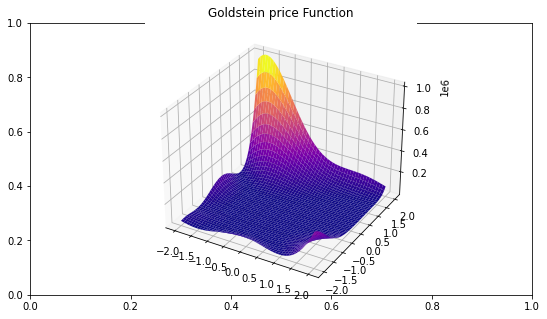

In [450]:
Plot_func(Goldstein_price_func,-2,2,-2,2,"Goldstein price Function");

target global min= 3  at  (0,-1)
result global min= 4.665828090000049  at  [-0.04 -1.06]


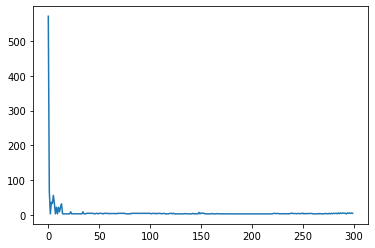

In [328]:
#Find the global minima of the Goldstein price function
GA_Find_GlobalMinima(Goldstein_price_func,1000,-2,2,100,300,0.3,0.06,Goldstein_price_func(0,-1),"(0,-1)");

<hr/>
<h3>Hartmann 3-D Function</h3>
<p>$f(x)=-\sum\limits_{i=1}^4{\alpha_i\exp\left(-\sum\limits_{j=1}^3{A_{ij}(x_j-P_{ij})^2}\right)}$</p>
<p>where $\alpha=(1.0,1.2,3.0,3.2)^T$</p>
<p> $A=\begin{pmatrix}
3.0&10&30\\
0.1&10&35\\
3.0&10&30\\
0.1&10&35\\
\end{pmatrix}$</p>
<p> $P=10^{-4}\begin{pmatrix}
3689 & 1170 & 2673\\
4699 & 4387 & 7470\\
1091 & 8732 & 5547\\
381 & 5743 & 8828\\
\end{pmatrix}$</p>
<p>Domain $x_i\in[0,1]$ for all $i=1,2,3$</p>
<p>Global Minimum</p>
<p>$f(x^*)=-3.86278$ at $x^*=(0.114614,0.555649,0.852547)$</p>

In [348]:
def Hartmann3D_func(x,y):
    alpha=[1.0,1.2,3.0,3.2];
    A=[[3,10,30],[0.1,10,35],[3,10,30],[0.1,10,35]];
    P=np.array([[3689,1170,2673],[4699,4387,7470],[1091,8732,5547],[381,5743,8828]])/(10**4);
    result=0;
    x3=0.852547;
    nx=[x,y,x3];
    for i in range(4):
        ksum=0;
        for j in range(3):
            ksum-=(A[i][j]*(nx[j]-P[i][j])**2);
        result-=alpha[i]*np.exp(ksum);
    return result;

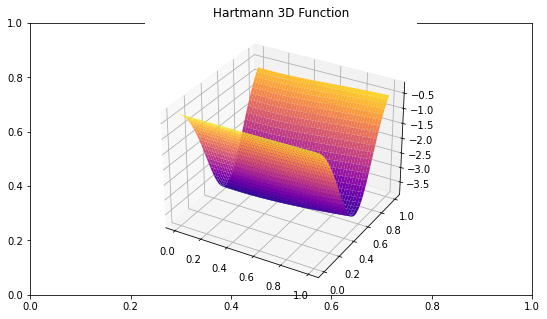

In [451]:
Plot_func(Hartmann3D_func,0,1,0,1,"Hartmann 3D Function");

target global min= -3.8627797869493365  at  (0.114614,0.555649)
result global min= -3.8294930312947812  at  [-0.12  0.55]


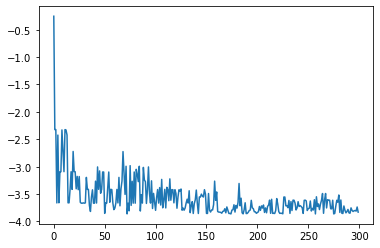

In [350]:
#Find the global minima of the Hartmann 3D function
GA_Find_GlobalMinima(Hartmann3D_func,1000,0,1,100,300,0.99,0.06,Hartmann3D_func(0.114614,0.555649),"(0.114614,0.555649)");

<hr/>
<h3>Hartmann 4-D Function</h3>
<p>$f(x)=\frac{1}{0.839}\left[1.1-\sum\limits_{i=1}^4{\alpha_i\exp\left(-\sum\limits_{j=1}^4{A_{ij}(x_j-P_{ij})^2}\right)}\right]$</p>
<p>where $\alpha=(1.0,1.2,3.0,3.2)^T$</p>
<p> $A=\begin{pmatrix}
10&3&17&3.50&1.7&8\\
0.05&10&17&0.1&8&14\\
3&3.5&1.7&10&17&8\\
17&8&0.05&10&0.1&14\\
\end{pmatrix}$</p>
<p> $P=10^{-4}\begin{pmatrix}
1312&1696&5569&124&8283&5886\\
2329&4135&8307&3736&1004&9991\\
2348&1451&3522&2883&3047&6650\\
4047&8828&8732&5743&1091&381\\
\end{pmatrix}$</p>
<p>Domain $x_i\in[0,1]$ for all $i=1,2,3$</p>


In [453]:
def Hartmann_4D_func(x,y):
    alpha=[1.0,1.2,3.0,3.2];
    A=[[10,3,17,3.5,1.7,8],
       [0.05,10,17,0.1,8,14],
       [3,3.5,1.7,10,17,8],
       [17,8,0.05,10,0.1,14]];
    P=np.array([[1312,1696,5569,124,8283,5886],
                [2329,4135,8307,3736,1004,9991],
                [2348,1451,3522,2883,3047,6650],
                [4047,8828,8732,5743,1091,381]])/(10**4);
    result=1.1;
    nx=[x,y,0,0];
    for i in range(4):
        ksum=0;
        for j in range(4):
            ksum-=(A[i][j]*(nx[j]-P[i][j])**2);
        result-=alpha[i]*np.exp(ksum);
    return result/0.839;

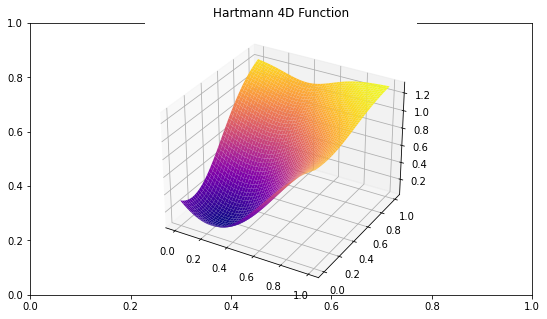

In [454]:
Plot_func(Hartmann_4D_func,0,1,0,1,"Hartmann 4D Function");

target global min= unknown  at  unknown
result global min= 0.04410595691566101  at  [0.23 0.16]


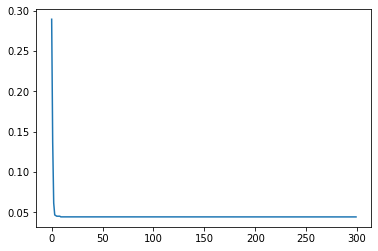

In [455]:
#Find the global minima of the Hartmann 4D function
GA_Find_GlobalMinima(Hartmann_4D_func,1000,0,1,100,300,0.99,0.06,"unknown","unknown");

<hr/>
<h3>Hartmann 6-D Function</h3>
<p>$f(x)=-\sum\limits_{i=1}^4{\alpha_i\exp\left(-\sum\limits_{j=1}^6{A_{ij}(x_j-P_{ij})^2}\right)}$</p>
<p>where $\alpha=(1.0,1.2,3.0,3.2)^T$</p>
<p> $A=\begin{pmatrix}
10&3&17&3.50&1.7&8\\
0.05&10&17&0.1&8&14\\
3&3.5&1.7&10&17&8\\
17&8&0.05&10&0.1&14\\
\end{pmatrix}$</p>
<p> $P=10^{-4}\begin{pmatrix}
1312&1696&5569&124&8283&5886\\
2329&4135&8307&3736&1004&9991\\
2348&1451&3522&2883&3047&6650\\
4047&8828&8732&5743&1091&381\\
\end{pmatrix}$</p>
<p>Domain $x_i\in[0,1]$ for all $i=1,2,..,6$</p>
<p>Global Minimum</p>
<p>$f(x^*)=-3.32237$ at $x^*=(0.20169,0.150011,0.476874,0.275332,0.311652,0.6573)$</p>


In [366]:
def Hartmann_6D_func(x,y):
    alpha=[1.0,1.2,3.0,3.2];
    A=[[10,3,17,3.5,1.7,8],
       [0.05,10,17,0.1,8,14],
       [3,3.5,1.7,10,17,8],
       [17,8,0.05,10,0.1,14]];
    P=np.array([[1312,1696,5569,124,8283,5886],
                [2329,4135,8307,3736,1004,9991],
                [2348,1451,3522,2883,3047,6650],
                [4047,8828,8732,5743,1091,381]])/(10**4);
    result=0;
    nx=[x,y,0.476874,0.275332,0.311652,0.6573];
    for i in range(4):
        ksum=0;
        for j in range(6):
            ksum-=(A[i][j]*(nx[j]-P[i][j])**2);
        result-=alpha[i]*np.exp(ksum);
    return result;

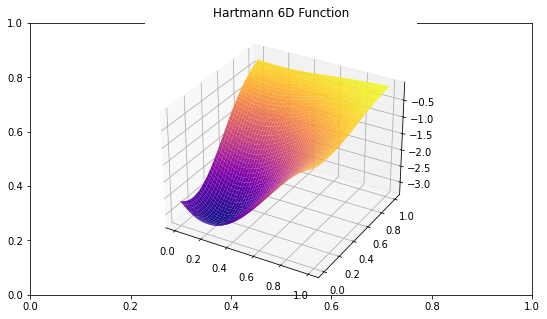

In [456]:
Plot_func(Hartmann_6D_func,0,1,0,1,"Hartmann 6D Function");

target global min= -3.322368011391339  at  (0.20169,0.150011)
result global min= -3.0097041493741243  at  [0.2  0.32]


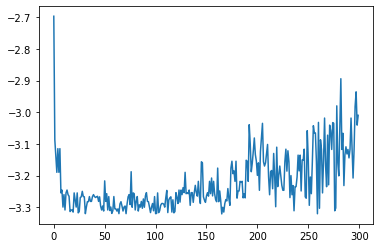

In [368]:
#Find the global minima of the Hartmann 6D function
GA_Find_GlobalMinima(Hartmann_6D_func,1000,0,1,100,300,0.99,0.06,Hartmann_6D_func(0.20169,0.150011),"(0.20169,0.150011)");

<hr/>
<h3>Perm Function D,Beta</h3>
<p>$f(x)=\sum\limits_{i=1}^d{\left(\sum\limits_{j=1}^d{(j^i+\beta)\left(\left(\frac{x_j}{j}\right)^i-1\right)}\right)^2}$</p>
<p>Beta-> optional constant, with default value of 0.5</p>
<p>So for 2D (i.e. d=2)<br/>
$f(x)=\left((1+\beta)\left(x-1\right)+(2+\beta)\left(\frac{y}{2}-1\right)\right)^2+\left((1+\beta)\left(x^2-1\right)+(4+\beta)\left(\left(\frac{y}{2}\right)^2-1\right)\right)^2$</p>
<p>Domain $x_i\in[-d,d]$ for all $i=1,...d$</p>
<p>Global Minimum</p>
<p>$f(x^*)=0$ at $x^*=(1,2,...,d)$</p>

In [372]:
def Perm_func(x,y):
    b=0.5;
    return ((1+b)*(x-1)+(2+b)*(y/2-1))**2+((1+b)*(x**2-1)+(4+b)*((y/2)**2-1))**2;

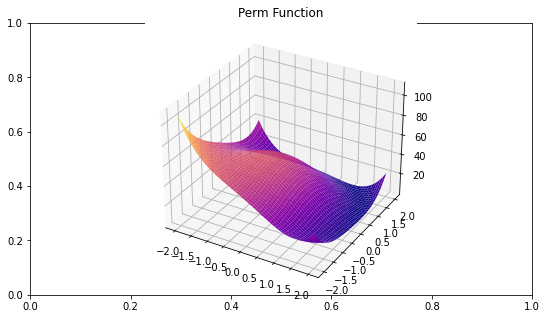

In [457]:
Plot_func(Perm_func,-2,2,-2,2,"Perm Function");

target global min= 0.0  at  (1,2)
result global min= 0.0018296514062500053  at  [1.07 1.95]


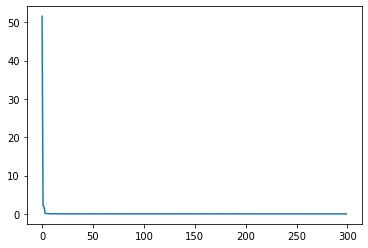

In [376]:
#Find the global minima of the Perm function
GA_Find_GlobalMinima(Perm_func,1000,-2,2,100,300,0.5,0.08,Perm_func(1,2),"(1,2)");

<hr/>
<h3>Powell Function</h3>
<p>$f(x)=\sum\limits_{i=1}^{d/4}{\left[(x_{4i-3}+10x_{4i-2})^2+5(x_{4i-1}-x_{4i})^2+(x_{4i-2}-2x_{4i-1})^4+10(x_{4i-3}-x_{4i})^4\right]}$</p>
<p>So, for 2D<br/>
    $f(x,y)=\left[(x+10y)^2+y^4+10x^4\right]$</p>
<p>Domain $x_i\in[-4,5]$ for all $i=1,..,d$</p>
<p>Global Minimum</p>
<p>$f(x^*)=0$ at $x*=(0,..,0)$</p>

In [377]:
def Powell_func(x,y):
    return ((x+10*y)**2+y**4+10*x**4);

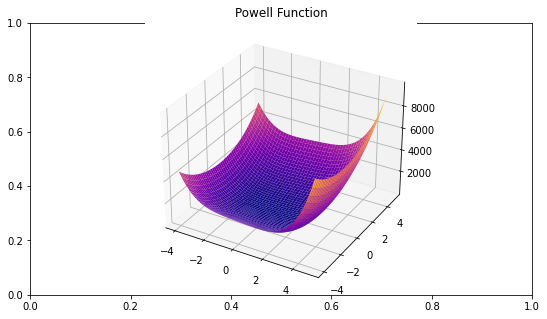

In [458]:
Plot_func(Powell_func,-4,5,-4,5,"Powell Function");

target global min= 0  at  (0,0)
result global min= 0.10987185000000002  at  [ 0.28 -0.05]


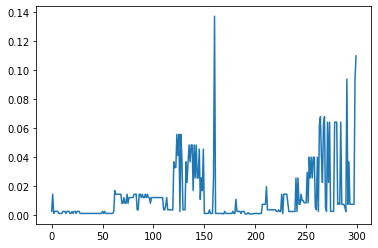

In [380]:
#Find the global minima of the Powell function
GA_Find_GlobalMinima(Powell_func,1000,-4,5,100,300,0.9,0.08,Powell_func(0,0),"(0,0)");

<hr/>
<h3>Shekel Function</h3>
<p>$f(x)=-\sum\limits_{i=1}^m{\left(\sum\limits_{j=1}^4{(x_j-C_{ji})^2+\beta_i}\right)^{-1}}$</p>
<p>where $m=10$</p>
<p>$\beta=\frac{1}{10}(1,2,2,4,4,6,3,7,5,5)^T$</p>
<p> $C=\begin{pmatrix}
4.0&1.0&8.0&6.0&3.0&2.0&5.0&8.0&6.0&7.0\\
4.0&1.0&8.0&6.0&7.0&9.0&3.0&1.0&2.0&3.6\\
4.0&1.0&8.0&6.0&3.0&2.0&5.0&8.0&6.0&7.0\\
4.0&1.0&8.0&6.0&7.0&9.0&3.0&1.0&2.0&3.6\\
\end{pmatrix}$</p>
<p>Domain $x_i\in[0,10]$ for all $i=1,2,3,4$</p>
<p>Global Minimum</p>
<p>at $m=5: f(x^*)=-10.1532$ at $x^*=(4,4,4,4)$</p>
<p>at $m=7: f(x^*)=-10.4029$ at $x^*=(4,4,4,4)$</p>
<p>at $m=10: f(x^*)=-10.5364$ at $x^*=(4,4,4,4)$</p>



In [381]:
def Shekel_func(x,y):
    b=np.array([1,2,2,4,4,6,3,7,5,5])/10;
    C=np.array([[4,1,8,6,3,2,5,8,6,7],
                [4,1,8,6,7,9,3,1,2,3.6],
                [4,1,8,6,3,2,5,8,6,7],
                [4,1,8,6,7,9,3,1,2,3.6]]);
    nx=[x,y,4,4];
    result=0;
    for i in range(10):
        jsum=0;
        for j in range (4):
            jsum+=((nx[j]-C[j][i])**2+b[i]);
        result-=(1/jsum);
    return result;

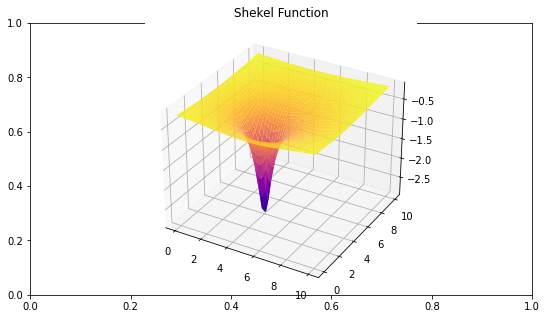

In [459]:
Plot_func(Shekel_func,0,10,0,10,"Shekel Function");

target global min= -2.9782920215419546  at  (4,4)
result global min= -1.674162643724859  at  [4.07 3.32]


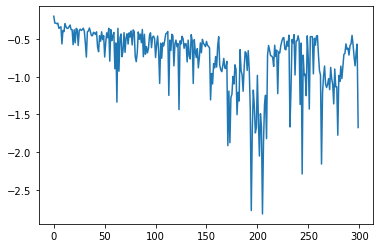

In [385]:
#Find the global minima of the Shekel function
GA_Find_GlobalMinima(Shekel_func,1000,0,10,100,300,0.99,0.06,Shekel_func(4,4),"(4,4)");

<hr/>
<h3>Styblinski-Tang Function</h3>
<p>$f(x)=\frac{1}{2}\sum\limits_{i=1}^d{(x_i^4-16x_i^2+5x_i)}$</p>
<p>So, for 2D<br/>
    $f(x,y)=\frac{1}{2}(x^4-16x^2+5x+y^4-16y^2+5y)$</p>
<p>Domain $x_i\in[-5,5]$ for all $i=1,..d$</p>
<p>Global Minimum</p>
<p>$f(x^*)=-39.16599d$ at $x^*=(-2.903534,...,-2.903534)$</p>
<p>So for 2D<br/>
    $f(x^*)=-78.33198$ at $x^*=(-2.903534,-2.903534)$</p>

In [386]:
def Styblinski_Tang_func(x,y):
    return 0.5*(x**4-16*x**2+5*x+y**4-16*y**2+5*y);

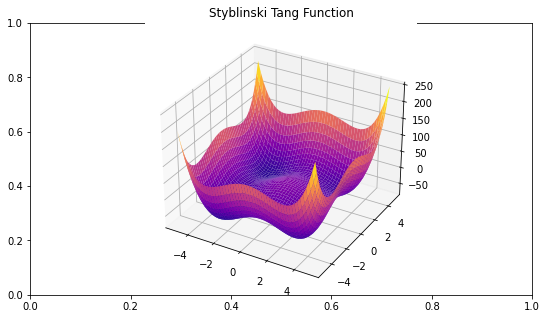

In [460]:
Plot_func(Styblinski_Tang_func,-5,5,-5,5,"Styblinski Tang Function");

target global min= -78.3323314075428  at  (−2.903534,−2.903534)
result global min= -72.10528511999999  at  [-2.32 -2.6 ]


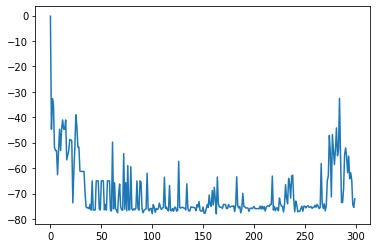

In [389]:
#Find the global minima of the Styblinski Tang function
GA_Find_GlobalMinima(Styblinski_Tang_func,1000,-5,5,100,300,0.8,0.06,Styblinski_Tang_func(-2.903534,-2.903534),"(−2.903534,−2.903534)");